In [1]:
# import numpy as np
# new = np.load('X_NEW_OHC.npy')
# new.shape

In [2]:
import numpy as np

in_path  = 'X_NEW_OHC.npy'
out_path = 'X_NEW_OHC_norm.npy'

CHANNEL_AXIS  = -1  
CHANNEL_INDEX = 8    

arr = np.load(in_path).astype(np.float32)

idx = [slice(None)] * arr.ndim
idx[CHANNEL_AXIS] = CHANNEL_INDEX
x = arr[tuple(idx)]

x = np.where(np.isfinite(x), x, np.nan)

mu  = np.nanmean(x)
std = np.nanstd(x)
if not np.isfinite(std) or std < 1e-12:
    std = 1.0
x_norm = (x - mu) / (std + 1e-8)
x_norm = np.nan_to_num(x_norm, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

arr[tuple(idx)] = x_norm
np.save(out_path, arr)

x_check = arr[tuple(idx)]

In [7]:
# create region dataset on Days*40*100 for cls if you already have the datasets it's no need to run the code
import os
import numpy as np

# Output file paths
hurr_path = 'region_hurr.npy'
env_path  = 'region_env_28.npy'

# # If both files already exist, skip creation and saving
# if os.path.exists(hurr_path) and os.path.exists(env_path):
#     print(f"Dataset already exists ({hurr_path}, {env_path}), skipping creation and saving.")
# else:
# 1. Load original data
hurr_loc = np.load('HURR_LOC_DAILY.npy')  # shape: (5133, 90, 180)
env_data = np.load('X_28.npy')           # shape: (5133, 90, 180, 27)

# 2. Crop region: lat 45:85 → 40 rows; lon 80:180 → 100 cols
region_hurr = hurr_loc[:, 45:85, 80:180]      # → (5133, 40, 100)
region_env  = env_data[:, 45:85, 80:180, :]   # → (5133, 40, 100, 27)

# 3. Save to .npy
np.save(hurr_path, region_hurr)
np.save(env_path,  region_env)

In [4]:
# SELECTED_CHANNELS = [
#     27,  # 500 Saturation Deficit
#     16,  # Surface radiation
#      9,  # 500 cloud cover
#     10,  # 500 Vorticity (relative)
#      6,  # 850 Vorticity (relative)
#     12,  # Potential Intensity
#      7,  # 850 Specific humidity
#     11,  # Vertical Shear
#     25,  # OHC
# ]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

# Hyperparameters
SEQ_LEN      = 14
STRIDE       = 3
IN_CH        = 9
H, W         = 40, 100
BATCH_SIZE   = 8
LR           = 1e-4
WEIGHT_DECAY = 1e-5

PATCH_H, PATCH_W = 20, 20
N_LAT_PATCHES, N_LON_PATCHES = 2, 5
P = N_LAT_PATCHES * N_LON_PATCHES

class HurricanePatchDataset(Dataset):
    def __init__(self, env_path, hurr_path, seq_len=SEQ_LEN, stride=STRIDE):
        # Load and sanitize
        env_all  = np.nan_to_num(np.load(env_path),   nan=0.0, posinf=0.0, neginf=0.0)  # (D, H, W, 28)
        hurr_all = np.nan_to_num(np.load(hurr_path),  nan=0.0, posinf=0.0, neginf=0.0)  # (D, H, W)

        # env_all = env_all[..., SELECTED_CHANNELS]  # (D, H, W, 9)

        self.env  = torch.from_numpy(env_all).float()   # (D, H, W, IN_CH)
        self.hurr = torch.from_numpy(hurr_all).float()  # (D, H, W)
        self.seq_len = seq_len

        D = env_all.shape[0]
        all_starts = list(range(0, D - seq_len + 1, stride))
        self.starts = [
            s for s in all_starts
            if (hurr_all[s:s+seq_len].reshape(seq_len, -1).sum(axis=1) > 0).any()
        ]

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx):
        s = self.starts[idx]
        # (T, C, H, W)
        x = self.env[s:s+self.seq_len].permute(0, 3, 1, 2)
        # (T, H, W)
        h = self.hurr[s:s+self.seq_len]
        h_patches = (
            h.reshape(self.seq_len,
                      N_LAT_PATCHES, PATCH_H,
                      N_LON_PATCHES, PATCH_W)
             .permute(0, 1, 3, 2, 4)
        )
        y = (h_patches.reshape(self.seq_len, P, PATCH_H*PATCH_W)
                  .sum(dim=2) > 0).long()
        y = y.view(self.seq_len, N_LAT_PATCHES, N_LON_PATCHES)
        return x, y, h_patches, s

dataset   = HurricanePatchDataset('region_env_9.npy', 'region_hurr.npy')
n_train   = int(len(dataset) * 0.9)
train_ds, val_ds = random_split(dataset, [n_train, len(dataset) - n_train])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [2]:
import torch.nn.functional as F

class FactorizedSTBlock(nn.Module):
    def __init__(self, E, num_heads, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        self.norm_sp = nn.LayerNorm(E)
        self.attn_sp = nn.MultiheadAttention(E, num_heads, dropout=drop)
        self.norm_tp = nn.LayerNorm(E)
        self.attn_tp = nn.MultiheadAttention(E, num_heads, dropout=drop)
        self.norm_mlp = nn.LayerNorm(E)
        hid = int(E * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(E, hid),
            nn.GELU(),
            nn.Linear(hid, E),
        )

    def forward(self, x):
        B, T, P, E = x.shape
        # spatial
        sp = x.reshape(B*T, P, E).transpose(0,1)
        o_sp, _ = self.attn_sp(sp, sp, sp)
        o_sp = o_sp.transpose(0,1).reshape(B, T, P, E)
        x = x + self.norm_sp(o_sp)
        # temporal
        tp = x.permute(2,0,1,3).reshape(P*B, T, E).transpose(0,1)
        o_tp, _ = self.attn_tp(tp, tp, tp)
        o_tp = o_tp.transpose(0,1).reshape(P, B, T, E).permute(1,2,0,3)
        x = x + self.norm_tp(o_tp)
        # MLP
        x = x + self.mlp(self.norm_mlp(x))
        return x

class RevisedHierarchicalPatchTimesformer(nn.Module):
    def __init__(self,
                 seq_len=SEQ_LEN,
                 in_ch=IN_CH,
                 H=H, W=W,
                 small_patch_h=2, small_patch_w=2,   # ← changed here
                 patch_h=20, patch_w=20,
                 embed_small=64,
                 depth_small=2,
                 embed_large=128,
                 depth_large=4,
                 num_heads=8):
        super().__init__()
        self.seq_len = seq_len
        self.sh, self.sw = small_patch_h, small_patch_w
        self.ph, self.pw = patch_h, patch_w
        self.n_slat = H // small_patch_h
        self.n_slon = W // small_patch_w
        self.n_lat  = H // patch_h
        self.n_lon  = W // patch_w
        P_small = self.n_slat * self.n_slon
        P_large = self.n_lat  * self.n_lon

        # small-patch embedding + ST
        self.small_proj = nn.Linear(in_ch * small_patch_h * small_patch_w, embed_small)
        self.pos_sp_small = nn.Parameter(torch.zeros(1,1,P_small,embed_small))
        self.pos_tp_small = nn.Parameter(torch.zeros(1,seq_len,1,embed_small))
        self.blocks_small = nn.ModuleList([
            FactorizedSTBlock(embed_small, num_heads)
            for _ in range(depth_small)
        ])
        self.norm_small = nn.LayerNorm(embed_small)

        # large-patch embedding + ST
        self.skip_proj  = nn.Linear(embed_small, embed_large)
        self.large_proj = nn.Linear(embed_small, embed_large)
        self.pos_sp_large = nn.Parameter(torch.zeros(1,1,P_large,embed_large))
        self.pos_tp_large = nn.Parameter(torch.zeros(1,seq_len,1,embed_large))
        self.blocks_large = nn.ModuleList([
            FactorizedSTBlock(embed_large, num_heads)
            for _ in range(depth_large)
        ])
        self.norm_large = nn.LayerNorm(embed_large)

        # final head
        self.head = nn.Linear(embed_large, 1)

        # init pos emb
        for p in [self.pos_sp_small, self.pos_tp_small, self.pos_sp_large, self.pos_tp_large]:
            nn.init.trunc_normal_(p, std=0.02)

    def forward(self, x):
        B, T, C, H, W = x.shape
        # small-patch extraction
        x_s = x.view(B, T, C, self.n_slat, self.sh, self.n_slon, self.sw)
        x_s = x_s.permute(0,1,3,5,2,4,6).contiguous()
        x_s = x_s.view(B, T, self.n_slat*self.n_slon, C*self.sh*self.sw)

        # small-patch ST
        z_s = self.small_proj(x_s)
        z_s = z_s + self.pos_sp_small + self.pos_tp_small
        for blk in self.blocks_small:
            z_s = blk(z_s)
        z_s = self.norm_small(z_s)

        # aggregate → large patches
        z_s2 = z_s.view(B, T, self.n_lat, self.ph//self.sh,
                        self.n_lon, self.pw//self.sw, -1)
        z_pooled = z_s2.mean(dim=5).mean(dim=3)
        z_l_small = z_pooled.view(B, T, self.n_lat*self.n_lon, -1)

        # large-patch ST
        skip = self.skip_proj(z_l_small)
        z_l  = self.large_proj(z_l_small) + skip
        z_l  = z_l + self.pos_sp_large + self.pos_tp_large
        for blk in self.blocks_large:
            z_l = blk(z_l)
        z_l = self.norm_large(z_l)

        logits = self.head(z_l).squeeze(-1).view(B, T, self.n_lat, self.n_lon)
        return logits


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RevisedHierarchicalPatchTimesformer().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


In [4]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

Epoch 1 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 0.0874, Acc: 0.9842, Prec: 0.0104, Rec: 0.0007, F1: 0.0014 | Val   Loss: 0.0752, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 2 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 0.0768, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0749, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 3 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 0.0765, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0746, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 4 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.0764, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0744, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 5 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.0755, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0751, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


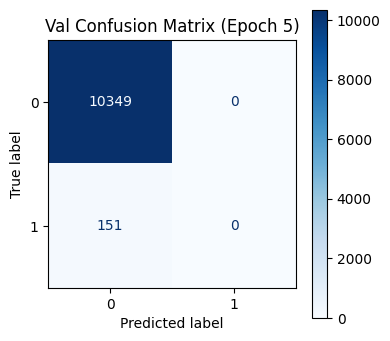

Epoch 6 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.0733, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0695, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 7 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.0702, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0667, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 8 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.0695, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0673, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 9 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.0689, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0658, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 10 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.0683, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0649, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


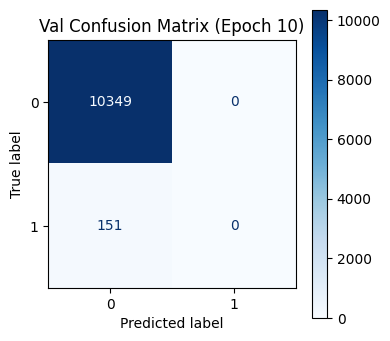

Epoch 11 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 11 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.0678, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0647, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 12 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 12 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.0677, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0649, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 13 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 13 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.0675, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0649, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 14 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 14 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.0670, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0641, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 15 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 15 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.0667, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0641, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


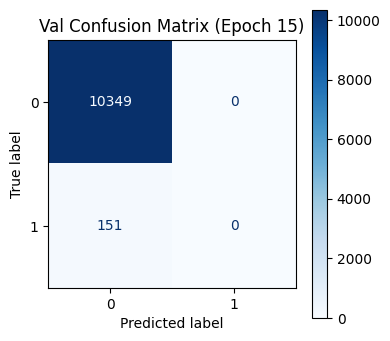

Epoch 16 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 16 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.0661, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0630, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 17 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 17 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.0655, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0652, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 18 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 18 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.0644, Acc: 0.9852, Prec: 0.4000, Rec: 0.0015, F1: 0.0029 | Val   Loss: 0.0614, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 19 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 19 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.0632, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0606, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 20 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 20 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.0624, Acc: 0.9852, Prec: 0.5000, Rec: 0.0029, F1: 0.0058 | Val   Loss: 0.0602, Acc: 0.9855, Prec: 0.4000, Rec: 0.0132, F1: 0.0256
→ Saved new best model (Val F1: 0.0256)


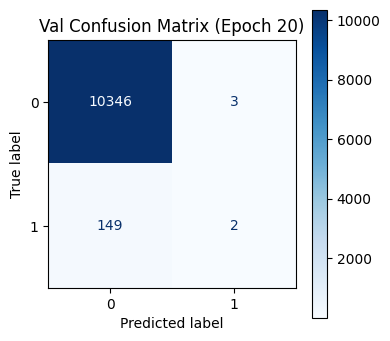

Epoch 21 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 21 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.0613, Acc: 0.9852, Prec: 0.5385, Rec: 0.0051, F1: 0.0101 | Val   Loss: 0.0602, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 22 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 22 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.0606, Acc: 0.9852, Prec: 0.5625, Rec: 0.0065, F1: 0.0129 | Val   Loss: 0.0607, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 23 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 23 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.0600, Acc: 0.9853, Prec: 0.7895, Rec: 0.0109, F1: 0.0215 | Val   Loss: 0.0581, Acc: 0.9855, Prec: 0.4667, Rec: 0.0464, F1: 0.0843
→ Saved new best model (Val F1: 0.0843)


Epoch 24 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 24 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.0579, Acc: 0.9853, Prec: 0.5862, Rec: 0.0123, F1: 0.0242 | Val   Loss: 0.0602, Acc: 0.9856, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 25 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 25 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.0567, Acc: 0.9854, Prec: 0.8000, Rec: 0.0174, F1: 0.0341 | Val   Loss: 0.0579, Acc: 0.9846, Prec: 0.3429, Rec: 0.0795, F1: 0.1290
→ Saved new best model (Val F1: 0.1290)


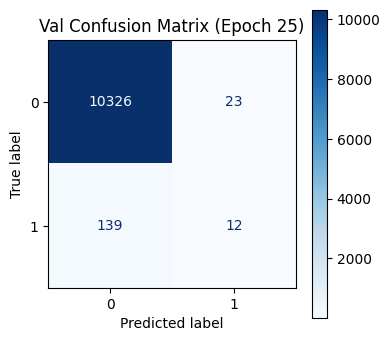

Epoch 26 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 26 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.0549, Acc: 0.9853, Prec: 0.5797, Rec: 0.0290, F1: 0.0553 | Val   Loss: 0.0553, Acc: 0.9861, Prec: 0.7273, Rec: 0.0530, F1: 0.0988


Epoch 27 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 27 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.0538, Acc: 0.9856, Prec: 0.7534, Rec: 0.0399, F1: 0.0758 | Val   Loss: 0.0546, Acc: 0.9857, Prec: 0.5714, Rec: 0.0265, F1: 0.0506


Epoch 28 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 28 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.0537, Acc: 0.9854, Prec: 0.6125, Rec: 0.0356, F1: 0.0672 | Val   Loss: 0.0538, Acc: 0.9858, Prec: 0.5357, Rec: 0.0993, F1: 0.1676
→ Saved new best model (Val F1: 0.1676)


Epoch 29 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 29 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.0505, Acc: 0.9860, Prec: 0.7285, Rec: 0.0798, F1: 0.1439 | Val   Loss: 0.0540, Acc: 0.9861, Prec: 0.6667, Rec: 0.0662, F1: 0.1205


Epoch 30 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 30 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.0499, Acc: 0.9857, Prec: 0.6597, Rec: 0.0689, F1: 0.1248 | Val   Loss: 0.0521, Acc: 0.9857, Prec: 0.6667, Rec: 0.0132, F1: 0.0260


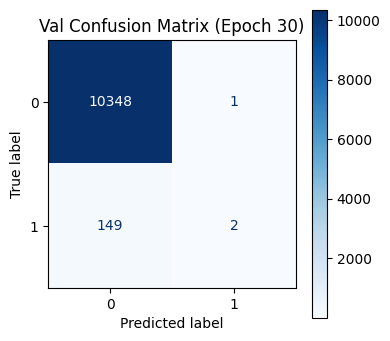

Epoch 31 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 31 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.0467, Acc: 0.9861, Prec: 0.6976, Rec: 0.1038, F1: 0.1807 | Val   Loss: 0.0498, Acc: 0.9858, Prec: 0.5278, Rec: 0.1258, F1: 0.2032
→ Saved new best model (Val F1: 0.2032)


Epoch 32 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 32 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.0444, Acc: 0.9862, Prec: 0.6667, Rec: 0.1364, F1: 0.2265 | Val   Loss: 0.0484, Acc: 0.9850, Prec: 0.4314, Rec: 0.1457, F1: 0.2178
→ Saved new best model (Val F1: 0.2178)


Epoch 33 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 33 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 0.0438, Acc: 0.9863, Prec: 0.6656, Rec: 0.1488, F1: 0.2432 | Val   Loss: 0.0487, Acc: 0.9861, Prec: 0.6667, Rec: 0.0662, F1: 0.1205


Epoch 34 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 34 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.0420, Acc: 0.9866, Prec: 0.6932, Rec: 0.1705, F1: 0.2737 | Val   Loss: 0.0464, Acc: 0.9855, Prec: 0.4884, Rec: 0.1391, F1: 0.2165


Epoch 35 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 35 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 0.0404, Acc: 0.9867, Prec: 0.6502, Rec: 0.2104, F1: 0.3180 | Val   Loss: 0.0467, Acc: 0.9861, Prec: 0.5926, Rec: 0.1060, F1: 0.1798


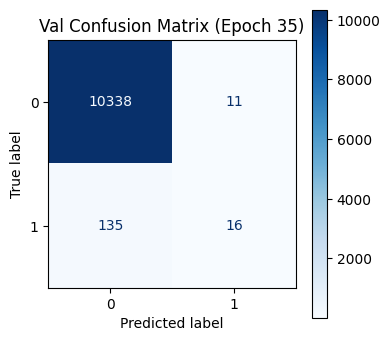

Epoch 36 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 36 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 | Train Loss: 0.0369, Acc: 0.9875, Prec: 0.6940, Rec: 0.2765, F1: 0.3954 | Val   Loss: 0.0479, Acc: 0.9860, Prec: 0.5357, Rec: 0.1987, F1: 0.2899
→ Saved new best model (Val F1: 0.2899)


Epoch 37 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 37 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.0358, Acc: 0.9878, Prec: 0.7095, Rec: 0.2925, F1: 0.4142 | Val   Loss: 0.0431, Acc: 0.9861, Prec: 0.5294, Rec: 0.2980, F1: 0.3814
→ Saved new best model (Val F1: 0.3814)


Epoch 38 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 38 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 | Train Loss: 0.0338, Acc: 0.9885, Prec: 0.7359, Rec: 0.3498, F1: 0.4742 | Val   Loss: 0.0453, Acc: 0.9856, Prec: 0.5000, Rec: 0.2517, F1: 0.3348


Epoch 39 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 39 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 | Train Loss: 0.0319, Acc: 0.9890, Prec: 0.7472, Rec: 0.3861, F1: 0.5091 | Val   Loss: 0.0446, Acc: 0.9849, Prec: 0.4608, Rec: 0.3113, F1: 0.3715


Epoch 40 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 40 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 | Train Loss: 0.0298, Acc: 0.9896, Prec: 0.7485, Rec: 0.4470, F1: 0.5597 | Val   Loss: 0.0419, Acc: 0.9865, Prec: 0.5763, Rec: 0.2252, F1: 0.3238


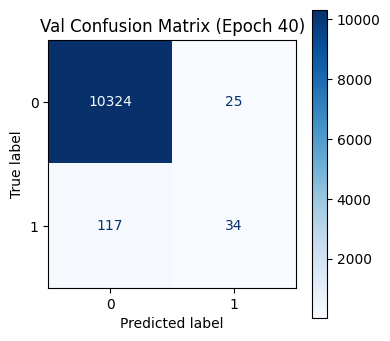

Epoch 41 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 41 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 | Train Loss: 0.0286, Acc: 0.9898, Prec: 0.7545, Rec: 0.4594, F1: 0.5710 | Val   Loss: 0.0424, Acc: 0.9861, Prec: 0.5316, Rec: 0.2781, F1: 0.3652


Epoch 42 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 42 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 0.0259, Acc: 0.9909, Prec: 0.7743, Rec: 0.5377, F1: 0.6347 | Val   Loss: 0.0399, Acc: 0.9866, Prec: 0.6087, Rec: 0.1854, F1: 0.2843


Epoch 43 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 43 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 0.0244, Acc: 0.9912, Prec: 0.7819, Rec: 0.5595, F1: 0.6523 | Val   Loss: 0.0413, Acc: 0.9868, Prec: 0.5536, Rec: 0.4106, F1: 0.4715
→ Saved new best model (Val F1: 0.4715)


Epoch 44 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 44 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 0.0220, Acc: 0.9920, Prec: 0.7942, Rec: 0.6161, F1: 0.6939 | Val   Loss: 0.0386, Acc: 0.9868, Prec: 0.5638, Rec: 0.3510, F1: 0.4327


Epoch 45 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 45 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 | Train Loss: 0.0193, Acc: 0.9932, Prec: 0.8275, Rec: 0.6821, F1: 0.7478 | Val   Loss: 0.0389, Acc: 0.9883, Prec: 0.6795, Rec: 0.3510, F1: 0.4629


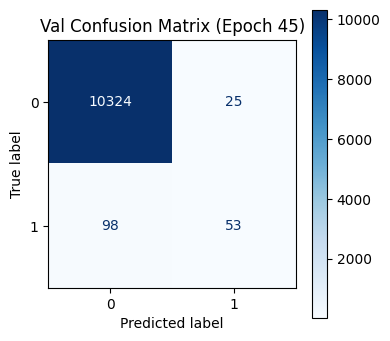

Epoch 46 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 46 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 | Train Loss: 0.0177, Acc: 0.9938, Prec: 0.8395, Rec: 0.7213, F1: 0.7760 | Val   Loss: 0.0404, Acc: 0.9878, Prec: 0.6075, Rec: 0.4305, F1: 0.5039
→ Saved new best model (Val F1: 0.5039)


Epoch 47 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 47 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 | Train Loss: 0.0159, Acc: 0.9943, Prec: 0.8503, Rec: 0.7460, F1: 0.7947 | Val   Loss: 0.0411, Acc: 0.9858, Prec: 0.5063, Rec: 0.5298, F1: 0.5178
→ Saved new best model (Val F1: 0.5178)


Epoch 48 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 48 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 | Train Loss: 0.0154, Acc: 0.9946, Prec: 0.8593, Rec: 0.7576, F1: 0.8052 | Val   Loss: 0.0327, Acc: 0.9884, Prec: 0.6142, Rec: 0.5166, F1: 0.5612
→ Saved new best model (Val F1: 0.5612)


Epoch 49 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 49 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 | Train Loss: 0.0146, Acc: 0.9947, Prec: 0.8535, Rec: 0.7779, F1: 0.8140 | Val   Loss: 0.0283, Acc: 0.9898, Prec: 0.6774, Rec: 0.5563, F1: 0.6109
→ Saved new best model (Val F1: 0.6109)


Epoch 50 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 50 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 | Train Loss: 0.0138, Acc: 0.9952, Prec: 0.8646, Rec: 0.7968, F1: 0.8293 | Val   Loss: 0.0315, Acc: 0.9905, Prec: 0.6977, Rec: 0.5960, F1: 0.6429
→ Saved new best model (Val F1: 0.6429)


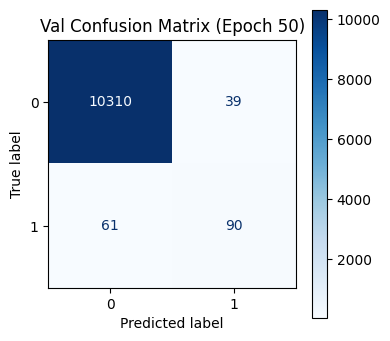

Epoch 51 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 51 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 51 | Train Loss: 0.0126, Acc: 0.9955, Prec: 0.8687, Rec: 0.8164, F1: 0.8418 | Val   Loss: 0.0297, Acc: 0.9894, Prec: 0.6389, Rec: 0.6093, F1: 0.6237


Epoch 52 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 52 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 52 | Train Loss: 0.0097, Acc: 0.9967, Prec: 0.9094, Rec: 0.8592, F1: 0.8836 | Val   Loss: 0.0349, Acc: 0.9897, Prec: 0.6201, Rec: 0.7351, F1: 0.6727
→ Saved new best model (Val F1: 0.6727)


Epoch 53 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 53 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 53 | Train Loss: 0.0096, Acc: 0.9967, Prec: 0.9092, Rec: 0.8643, F1: 0.8862 | Val   Loss: 0.0277, Acc: 0.9911, Prec: 0.6959, Rec: 0.6821, F1: 0.6890
→ Saved new best model (Val F1: 0.6890)


Epoch 54 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 54 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 54 | Train Loss: 0.0119, Acc: 0.9957, Prec: 0.8768, Rec: 0.8266, F1: 0.8510 | Val   Loss: 0.0318, Acc: 0.9901, Prec: 0.7080, Rec: 0.5298, F1: 0.6061


Epoch 55 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 55 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 55 | Train Loss: 0.0088, Acc: 0.9967, Prec: 0.9048, Rec: 0.8687, F1: 0.8863 | Val   Loss: 0.0255, Acc: 0.9923, Prec: 0.7215, Rec: 0.7550, F1: 0.7379
→ Saved new best model (Val F1: 0.7379)


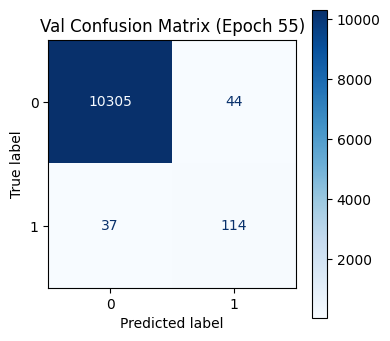

Epoch 56 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 56 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 56 | Train Loss: 0.0109, Acc: 0.9963, Prec: 0.8927, Rec: 0.8512, F1: 0.8715 | Val   Loss: 0.0271, Acc: 0.9910, Prec: 0.6939, Rec: 0.6755, F1: 0.6846


Epoch 57 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 57 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 57 | Train Loss: 0.0061, Acc: 0.9978, Prec: 0.9334, Rec: 0.9151, F1: 0.9241 | Val   Loss: 0.0267, Acc: 0.9926, Prec: 0.7704, Rec: 0.6887, F1: 0.7273


Epoch 58 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 58 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 58 | Train Loss: 0.0059, Acc: 0.9980, Prec: 0.9401, Rec: 0.9224, F1: 0.9311 | Val   Loss: 0.0321, Acc: 0.9905, Prec: 0.6689, Rec: 0.6689, F1: 0.6689


Epoch 59 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 59 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 59 | Train Loss: 0.0065, Acc: 0.9978, Prec: 0.9362, Rec: 0.9165, F1: 0.9263 | Val   Loss: 0.0302, Acc: 0.9909, Prec: 0.6923, Rec: 0.6556, F1: 0.6735


Epoch 60 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 60 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 60 | Train Loss: 0.0063, Acc: 0.9979, Prec: 0.9383, Rec: 0.9165, F1: 0.9273 | Val   Loss: 0.0322, Acc: 0.9910, Prec: 0.6750, Rec: 0.7152, F1: 0.6945


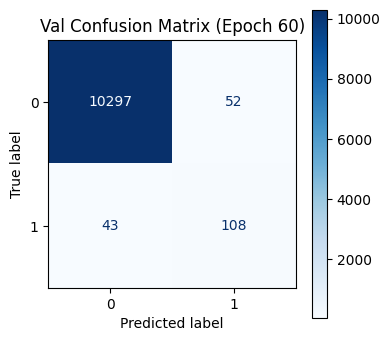

Epoch 61 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 61 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 61 | Train Loss: 0.0053, Acc: 0.9980, Prec: 0.9352, Rec: 0.9325, F1: 0.9339 | Val   Loss: 0.0270, Acc: 0.9928, Prec: 0.8378, Rec: 0.6159, F1: 0.7099


Epoch 62 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 62 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 62 | Train Loss: 0.0048, Acc: 0.9985, Prec: 0.9537, Rec: 0.9419, F1: 0.9478 | Val   Loss: 0.0301, Acc: 0.9929, Prec: 0.8393, Rec: 0.6225, F1: 0.7148


Epoch 63 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 63 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 63 | Train Loss: 0.0040, Acc: 0.9986, Prec: 0.9515, Rec: 0.9536, F1: 0.9525 | Val   Loss: 0.0263, Acc: 0.9922, Prec: 0.7347, Rec: 0.7152, F1: 0.7248


Epoch 64 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 64 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 64 | Train Loss: 0.0049, Acc: 0.9983, Prec: 0.9474, Rec: 0.9405, F1: 0.9439 | Val   Loss: 0.0276, Acc: 0.9930, Prec: 0.7955, Rec: 0.6954, F1: 0.7420
→ Saved new best model (Val F1: 0.7420)


Epoch 65 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 65 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 65 | Train Loss: 0.0061, Acc: 0.9979, Prec: 0.9359, Rec: 0.9224, F1: 0.9291 | Val   Loss: 0.0244, Acc: 0.9926, Prec: 0.7626, Rec: 0.7020, F1: 0.7310


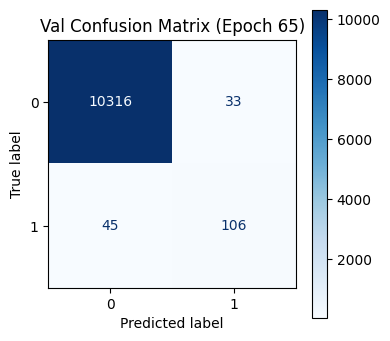

Epoch 66 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 66 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 66 | Train Loss: 0.0042, Acc: 0.9987, Prec: 0.9590, Rec: 0.9499, F1: 0.9544 | Val   Loss: 0.0271, Acc: 0.9930, Prec: 0.8362, Rec: 0.6424, F1: 0.7266


Epoch 67 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 67 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 67 | Train Loss: 0.0024, Acc: 0.9993, Prec: 0.9746, Rec: 0.9761, F1: 0.9753 | Val   Loss: 0.0196, Acc: 0.9949, Prec: 0.8540, Rec: 0.7748, F1: 0.8125
→ Saved new best model (Val F1: 0.8125)


Epoch 68 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 68 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 68 | Train Loss: 0.0014, Acc: 0.9996, Prec: 0.9855, Rec: 0.9855, F1: 0.9855 | Val   Loss: 0.0253, Acc: 0.9935, Prec: 0.7546, Rec: 0.8146, F1: 0.7834


Epoch 69 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 69 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 69 | Train Loss: 0.0073, Acc: 0.9974, Prec: 0.9203, Rec: 0.9049, F1: 0.9126 | Val   Loss: 0.0264, Acc: 0.9910, Prec: 0.6522, Rec: 0.7947, F1: 0.7164


Epoch 70 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 70 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 70 | Train Loss: 0.0064, Acc: 0.9977, Prec: 0.9345, Rec: 0.9115, F1: 0.9229 | Val   Loss: 0.0225, Acc: 0.9933, Prec: 0.7547, Rec: 0.7947, F1: 0.7742


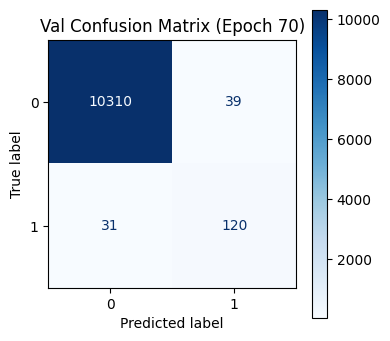

Epoch 71 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 71 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 71 | Train Loss: 0.0022, Acc: 0.9993, Prec: 0.9754, Rec: 0.9782, F1: 0.9768 | Val   Loss: 0.0298, Acc: 0.9926, Prec: 0.8120, Rec: 0.6291, F1: 0.7090


Epoch 72 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 72 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 72 | Train Loss: 0.0033, Acc: 0.9989, Prec: 0.9657, Rec: 0.9594, F1: 0.9625 | Val   Loss: 0.0234, Acc: 0.9936, Prec: 0.8182, Rec: 0.7152, F1: 0.7633


Epoch 73 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 73 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 73 | Train Loss: 0.0017, Acc: 0.9995, Prec: 0.9812, Rec: 0.9855, F1: 0.9833 | Val   Loss: 0.0228, Acc: 0.9946, Prec: 0.8672, Rec: 0.7351, F1: 0.7957


Epoch 74 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 74 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 74 | Train Loss: 0.0021, Acc: 0.9994, Prec: 0.9839, Rec: 0.9782, F1: 0.9811 | Val   Loss: 0.0242, Acc: 0.9936, Prec: 0.8231, Rec: 0.7086, F1: 0.7616


Epoch 75 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 75 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 75 | Train Loss: 0.0027, Acc: 0.9991, Prec: 0.9708, Rec: 0.9659, F1: 0.9684 | Val   Loss: 0.0246, Acc: 0.9940, Prec: 0.8333, Rec: 0.7285, F1: 0.7774


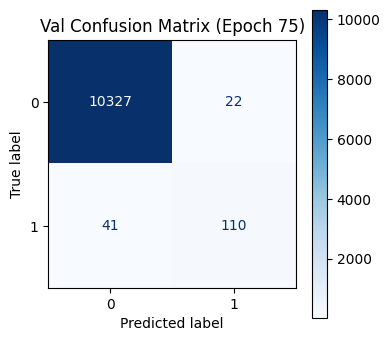

Epoch 76 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 76 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 76 | Train Loss: 0.0056, Acc: 0.9981, Prec: 0.9394, Rec: 0.9332, F1: 0.9363 | Val   Loss: 0.0210, Acc: 0.9950, Prec: 0.8403, Rec: 0.8013, F1: 0.8203
→ Saved new best model (Val F1: 0.8203)


Epoch 77 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 77 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 77 | Train Loss: 0.0032, Acc: 0.9989, Prec: 0.9678, Rec: 0.9608, F1: 0.9643 | Val   Loss: 0.0219, Acc: 0.9943, Prec: 0.7935, Rec: 0.8146, F1: 0.8039


Epoch 78 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 78 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 78 | Train Loss: 0.0030, Acc: 0.9990, Prec: 0.9679, Rec: 0.9630, F1: 0.9654 | Val   Loss: 0.0249, Acc: 0.9936, Prec: 0.8182, Rec: 0.7152, F1: 0.7633


Epoch 79 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 79 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 79 | Train Loss: 0.0032, Acc: 0.9989, Prec: 0.9643, Rec: 0.9601, F1: 0.9622 | Val   Loss: 0.0300, Acc: 0.9928, Prec: 0.7820, Rec: 0.6887, F1: 0.7324


Epoch 80 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 80 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 80 | Train Loss: 0.0037, Acc: 0.9987, Prec: 0.9598, Rec: 0.9536, F1: 0.9567 | Val   Loss: 0.0234, Acc: 0.9929, Prec: 0.8220, Rec: 0.6424, F1: 0.7212


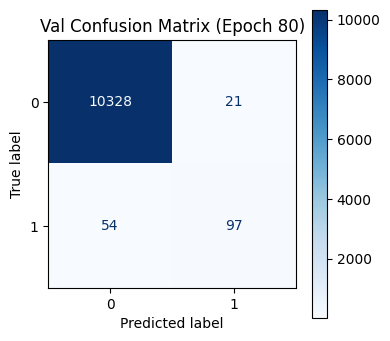

Epoch 81 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 81 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 81 | Train Loss: 0.0028, Acc: 0.9989, Prec: 0.9678, Rec: 0.9608, F1: 0.9643 | Val   Loss: 0.0214, Acc: 0.9941, Prec: 0.8618, Rec: 0.7020, F1: 0.7737


Epoch 82 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 82 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 82 | Train Loss: 0.0019, Acc: 0.9993, Prec: 0.9767, Rec: 0.9746, F1: 0.9757 | Val   Loss: 0.0266, Acc: 0.9940, Prec: 0.7973, Rec: 0.7815, F1: 0.7893


Epoch 83 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 83 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 83 | Train Loss: 0.0035, Acc: 0.9987, Prec: 0.9591, Rec: 0.9536, F1: 0.9563 | Val   Loss: 0.0226, Acc: 0.9942, Prec: 0.8409, Rec: 0.7351, F1: 0.7845


Epoch 84 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 84 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 84 | Train Loss: 0.0018, Acc: 0.9994, Prec: 0.9825, Rec: 0.9768, F1: 0.9796 | Val   Loss: 0.0285, Acc: 0.9942, Prec: 0.8814, Rec: 0.6887, F1: 0.7732


Epoch 85 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 85 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 85 | Train Loss: 0.0018, Acc: 0.9994, Prec: 0.9811, Rec: 0.9782, F1: 0.9797 | Val   Loss: 0.0240, Acc: 0.9940, Prec: 0.7973, Rec: 0.7815, F1: 0.7893


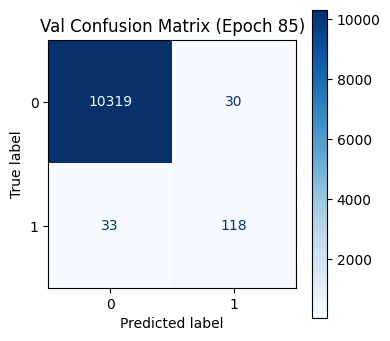

Epoch 86 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 86 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 86 | Train Loss: 0.0019, Acc: 0.9994, Prec: 0.9803, Rec: 0.9775, F1: 0.9789 | Val   Loss: 0.0239, Acc: 0.9935, Prec: 0.7823, Rec: 0.7616, F1: 0.7718


Epoch 87 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 87 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 87 | Train Loss: 0.0044, Acc: 0.9984, Prec: 0.9502, Rec: 0.9412, F1: 0.9457 | Val   Loss: 0.0339, Acc: 0.9917, Prec: 0.7000, Rec: 0.7417, F1: 0.7203


Epoch 88 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 88 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 88 | Train Loss: 0.0041, Acc: 0.9986, Prec: 0.9536, Rec: 0.9550, F1: 0.9543 | Val   Loss: 0.0223, Acc: 0.9944, Prec: 0.8433, Rec: 0.7483, F1: 0.7930


Epoch 89 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 89 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 89 | Train Loss: 0.0018, Acc: 0.9995, Prec: 0.9812, Rec: 0.9833, F1: 0.9822 | Val   Loss: 0.0252, Acc: 0.9945, Prec: 0.8550, Rec: 0.7417, F1: 0.7943


Epoch 90 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 90 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 90 | Train Loss: 0.0019, Acc: 0.9993, Prec: 0.9789, Rec: 0.9761, F1: 0.9775 | Val   Loss: 0.0280, Acc: 0.9930, Prec: 0.7868, Rec: 0.7086, F1: 0.7456


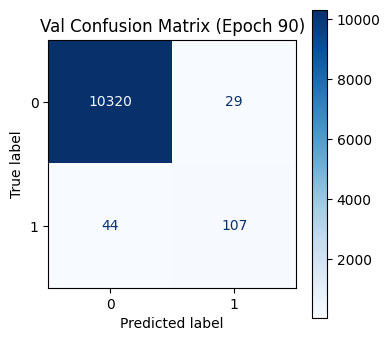

Epoch 91 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 91 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 91 | Train Loss: 0.0024, Acc: 0.9992, Prec: 0.9766, Rec: 0.9710, F1: 0.9738 | Val   Loss: 0.0215, Acc: 0.9946, Prec: 0.8672, Rec: 0.7351, F1: 0.7957


Epoch 92 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 92 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 92 | Train Loss: 0.0007, Acc: 0.9998, Prec: 0.9956, Rec: 0.9898, F1: 0.9927 | Val   Loss: 0.0243, Acc: 0.9945, Prec: 0.8207, Rec: 0.7881, F1: 0.8041


Epoch 93 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 93 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 93 | Train Loss: 0.0007, Acc: 0.9998, Prec: 0.9913, Rec: 0.9949, F1: 0.9931 | Val   Loss: 0.0264, Acc: 0.9951, Prec: 0.8846, Rec: 0.7616, F1: 0.8185


Epoch 94 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 94 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 94 | Train Loss: 0.0004, Acc: 0.9999, Prec: 0.9971, Rec: 0.9978, F1: 0.9975 | Val   Loss: 0.0213, Acc: 0.9954, Prec: 0.8705, Rec: 0.8013, F1: 0.8345
→ Saved new best model (Val F1: 0.8345)


Epoch 95 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 95 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 95 | Train Loss: 0.0001, Acc: 1.0000, Prec: 1.0000, Rec: 0.9993, F1: 0.9996 | Val   Loss: 0.0252, Acc: 0.9947, Prec: 0.8025, Rec: 0.8344, F1: 0.8182


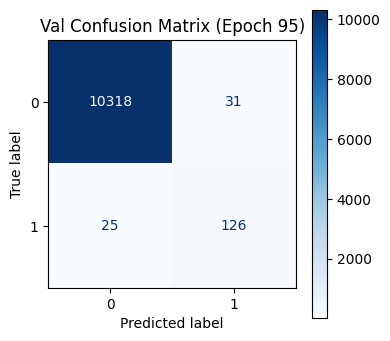

Epoch 96 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 96 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 96 | Train Loss: 0.0011, Acc: 0.9997, Prec: 0.9884, Rec: 0.9891, F1: 0.9888 | Val   Loss: 0.0306, Acc: 0.9941, Prec: 0.8504, Rec: 0.7152, F1: 0.7770


Epoch 97 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 97 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 97 | Train Loss: 0.0055, Acc: 0.9980, Prec: 0.9404, Rec: 0.9267, F1: 0.9335 | Val   Loss: 0.0255, Acc: 0.9925, Prec: 0.7535, Rec: 0.7086, F1: 0.7304


Epoch 98 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 98 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 98 | Train Loss: 0.0021, Acc: 0.9993, Prec: 0.9760, Rec: 0.9753, F1: 0.9757 | Val   Loss: 0.0191, Acc: 0.9954, Prec: 0.8652, Rec: 0.8079, F1: 0.8356
→ Saved new best model (Val F1: 0.8356)


Epoch 99 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 99 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 99 | Train Loss: 0.0036, Acc: 0.9988, Prec: 0.9587, Rec: 0.9608, F1: 0.9598 | Val   Loss: 0.0232, Acc: 0.9941, Prec: 0.7834, Rec: 0.8146, F1: 0.7987


Epoch 100 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 100 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 100 | Train Loss: 0.0021, Acc: 0.9994, Prec: 0.9839, Rec: 0.9782, F1: 0.9811 | Val   Loss: 0.0257, Acc: 0.9945, Prec: 0.8605, Rec: 0.7351, F1: 0.7929


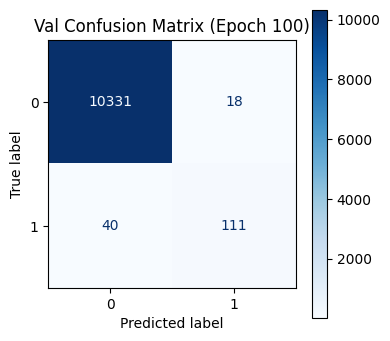

Epoch 101 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 101 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 101 | Train Loss: 0.0048, Acc: 0.9984, Prec: 0.9542, Rec: 0.9369, F1: 0.9454 | Val   Loss: 0.0210, Acc: 0.9944, Prec: 0.8833, Rec: 0.7020, F1: 0.7823


Epoch 102 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 102 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 102 | Train Loss: 0.0015, Acc: 0.9995, Prec: 0.9876, Rec: 0.9811, F1: 0.9843 | Val   Loss: 0.0195, Acc: 0.9951, Prec: 0.9032, Rec: 0.7417, F1: 0.8145


Epoch 103 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 103 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 103 | Train Loss: 0.0017, Acc: 0.9993, Prec: 0.9755, Rec: 0.9804, F1: 0.9779 | Val   Loss: 0.0276, Acc: 0.9931, Prec: 0.8835, Rec: 0.6026, F1: 0.7165


Epoch 104 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 104 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 104 | Train Loss: 0.0022, Acc: 0.9992, Prec: 0.9759, Rec: 0.9710, F1: 0.9734 | Val   Loss: 0.0217, Acc: 0.9942, Prec: 0.8516, Rec: 0.7219, F1: 0.7814


Epoch 105 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 105 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 105 | Train Loss: 0.0045, Acc: 0.9986, Prec: 0.9576, Rec: 0.9507, F1: 0.9541 | Val   Loss: 0.0180, Acc: 0.9939, Prec: 0.8042, Rec: 0.7616, F1: 0.7823


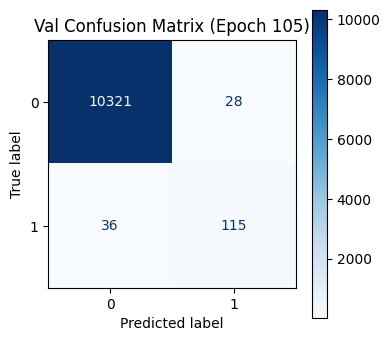

Epoch 106 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 106 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 106 | Train Loss: 0.0017, Acc: 0.9995, Prec: 0.9869, Rec: 0.9811, F1: 0.9840 | Val   Loss: 0.0229, Acc: 0.9944, Prec: 0.8538, Rec: 0.7351, F1: 0.7900


Epoch 107 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 107 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 107 | Train Loss: 0.0005, Acc: 0.9999, Prec: 0.9949, Rec: 0.9964, F1: 0.9956 | Val   Loss: 0.0182, Acc: 0.9955, Prec: 0.8714, Rec: 0.8079, F1: 0.8385
→ Saved new best model (Val F1: 0.8385)


Epoch 108 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 108 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 108 | Train Loss: 0.0002, Acc: 0.9999, Prec: 0.9978, Rec: 0.9985, F1: 0.9982 | Val   Loss: 0.0156, Acc: 0.9964, Prec: 0.8951, Rec: 0.8477, F1: 0.8707
→ Saved new best model (Val F1: 0.8707)


Epoch 109 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 109 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 109 | Train Loss: 0.0001, Acc: 1.0000, Prec: 0.9993, Rec: 1.0000, F1: 0.9996 | Val   Loss: 0.0176, Acc: 0.9964, Prec: 0.9007, Rec: 0.8411, F1: 0.8699


Epoch 110 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 110 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 110 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0173, Acc: 0.9965, Prec: 0.9071, Rec: 0.8411, F1: 0.8729
→ Saved new best model (Val F1: 0.8729)


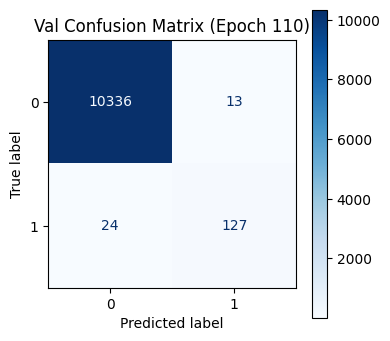

Epoch 111 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 111 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 111 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0173, Acc: 0.9966, Prec: 0.9137, Rec: 0.8411, F1: 0.8759
→ Saved new best model (Val F1: 0.8759)


Epoch 112 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 112 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 112 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0175, Acc: 0.9966, Prec: 0.9137, Rec: 0.8411, F1: 0.8759


Epoch 113 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 113 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 113 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0176, Acc: 0.9965, Prec: 0.9071, Rec: 0.8411, F1: 0.8729


Epoch 114 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 114 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 114 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0178, Acc: 0.9965, Prec: 0.9071, Rec: 0.8411, F1: 0.8729


Epoch 115 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 115 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 115 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0180, Acc: 0.9965, Prec: 0.9071, Rec: 0.8411, F1: 0.8729


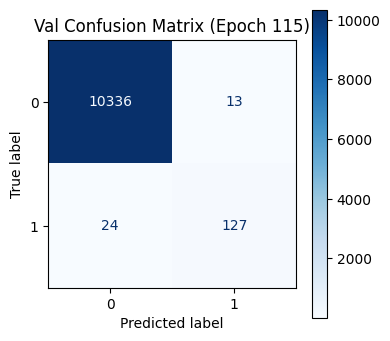

Epoch 116 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 116 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 116 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0181, Acc: 0.9966, Prec: 0.9137, Rec: 0.8411, F1: 0.8759


Epoch 117 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 117 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 117 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0183, Acc: 0.9965, Prec: 0.9071, Rec: 0.8411, F1: 0.8729


Epoch 118 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 118 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 118 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0184, Acc: 0.9965, Prec: 0.9071, Rec: 0.8411, F1: 0.8729


Epoch 119 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 119 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 119 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0186, Acc: 0.9964, Prec: 0.9007, Rec: 0.8411, F1: 0.8699


Epoch 120 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 120 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 120 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0188, Acc: 0.9964, Prec: 0.9007, Rec: 0.8411, F1: 0.8699


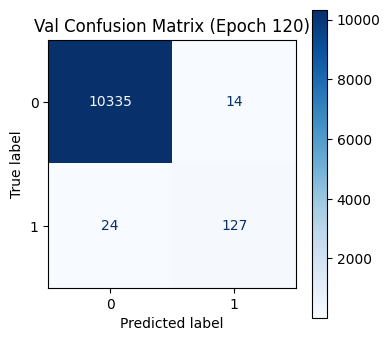

Epoch 121 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 121 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 121 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0189, Acc: 0.9963, Prec: 0.8944, Rec: 0.8411, F1: 0.8669


Epoch 122 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 122 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 122 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0191, Acc: 0.9963, Prec: 0.8944, Rec: 0.8411, F1: 0.8669


Epoch 123 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 123 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 123 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0192, Acc: 0.9963, Prec: 0.8944, Rec: 0.8411, F1: 0.8669


Epoch 124 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 124 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 124 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0194, Acc: 0.9962, Prec: 0.8881, Rec: 0.8411, F1: 0.8639


Epoch 125 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 125 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 125 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0196, Acc: 0.9963, Prec: 0.8944, Rec: 0.8411, F1: 0.8669


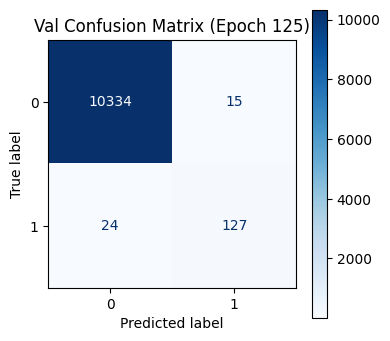

Epoch 126 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 126 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 126 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0197, Acc: 0.9963, Prec: 0.8944, Rec: 0.8411, F1: 0.8669


Epoch 127 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 127 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 127 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0199, Acc: 0.9963, Prec: 0.8889, Rec: 0.8477, F1: 0.8678


Epoch 128 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 128 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 128 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0200, Acc: 0.9963, Prec: 0.8889, Rec: 0.8477, F1: 0.8678


Epoch 129 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 129 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 129 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0202, Acc: 0.9963, Prec: 0.8889, Rec: 0.8477, F1: 0.8678


Epoch 130 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 130 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 130 | Train Loss: 0.0000, Acc: 1.0000, Prec: 1.0000, Rec: 1.0000, F1: 1.0000 | Val   Loss: 0.0204, Acc: 0.9963, Prec: 0.8889, Rec: 0.8477, F1: 0.8678


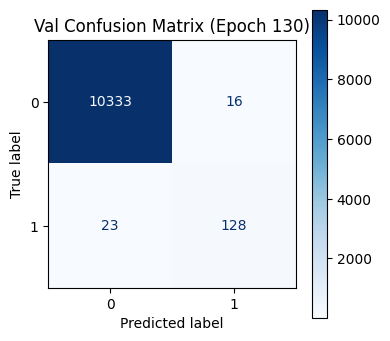

In [5]:
# Cell 4: Training Loop with Acc/Prec/Rec/F1 and Confusion Matrix
EPOCHS= 130

from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

best_val_f1 = 0.0

for epoch in range(1, EPOCHS + 1):
    # ——— Training ———
    model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_targets = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch} Train", leave=False)
    for x, y, *_ in loop:
        x, y = x.to(device), y.to(device).float()

        logits = model(x)
        loss   = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long().cpu().view(-1).numpy()
        targ  = y.cpu().view(-1).numpy()

        all_train_preds.extend(preds)
        all_train_targets.extend(targ)

        loop.set_postfix(train_loss=loss.item())

    train_loss /= len(train_ds)
    train_acc  = accuracy_score(all_train_targets, all_train_preds)
    train_prec = precision_score(all_train_targets, all_train_preds, zero_division=0)
    train_rec  = recall_score(all_train_targets, all_train_preds, zero_division=0)
    train_f1   = f1_score(all_train_targets, all_train_preds, zero_division=0)

    # ——— Validation ———
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_targets = []

    loop = tqdm(val_loader, desc=f"Epoch {epoch} Val", leave=False)
    with torch.no_grad():
        for x, y, *_ in loop:
            x, y = x.to(device), y.to(device).float()
            logits = model(x)
            loss   = criterion(logits, y)
            val_loss += loss.item() * x.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long().cpu().view(-1).numpy()
            targ  = y.cpu().view(-1).numpy()

            all_val_preds.extend(preds)
            all_val_targets.extend(targ)

            loop.set_postfix(val_loss=loss.item())

    val_loss /= len(val_ds)
    val_acc  = accuracy_score(all_val_targets, all_val_preds)
    val_prec = precision_score(all_val_targets, all_val_preds, zero_division=0)
    val_rec  = recall_score(all_val_targets, all_val_preds, zero_division=0)
    val_f1   = f1_score(all_val_targets, all_val_preds, zero_division=0)

    # ——— Print Metrics ———
    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f} | "
        f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}"
    )

    # ——— Save Best ———
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_patch_timesformer.pt")
        print(f"→ Saved new best model (Val F1: {val_f1:.4f})")

    # ——— Confusion Matrix Every 5 Epochs ———
    if epoch % 5 == 0 or epoch == EPOCHS:
        cm = confusion_matrix(all_val_targets, all_val_preds, labels=[0,1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        fig, ax = plt.subplots(figsize=(4,4))
        disp.plot(ax=ax, cmap='Blues', values_format='d')
        ax.set_title(f"Val Confusion Matrix (Epoch {epoch})")
        plt.show()

In [6]:
# Cell X: Compute & Save Per-Channel Saliency Maps (Patch-specific + Global) over Entire Validation Set

import os
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.ndimage import gaussian_filter


channel_names = ["Potential Intensity","Specific Humidity (850mb)","Vertical Shear","Relative Vorticity (500mb)","Relative Vorticity (850mb)",
                 "Saturation Deficit (500mb)","Surface Radiation","Cloud Cover (500mb)","Ocean Heat Content"]

# 1) Load & prep model
model = RevisedHierarchicalPatchTimesformer(
    seq_len=SEQ_LEN, in_ch=IN_CH,
    H=40, W=100,
    small_patch_h=2, small_patch_w=2,
    patch_h=20, patch_w=20,
    embed_small=64, depth_small=2,
    embed_large=128, depth_large=4,
    num_heads=8
).to(device)
model.load_state_dict(torch.load("best_patch_timesformer.pt", map_location=device))
model.eval()

# 2) IG parameters
steps = 20
alphas = torch.linspace(0.0, 1.0, steps, device=device)
factor = 2  # down-sample factor

# 3) Geographic bounds
n_lat_full, n_lon_full = 90, 180
region_lat0, region_lon0 = 45, 80
# retrieve H,W from one batch
sample_x, _, _, _ = next(iter(val_loader))
H, W = sample_x.shape[-2:]
lat_max =  90.0 - (region_lat0 + 0.5) * (90.0 / n_lat_full)
lat_min =  90.0 - (region_lat0 + H   - 0.5) * (90.0 / n_lat_full)
lon_min = -180.0 + (region_lon0 + 0.5) * (180.0 / n_lon_full)
lon_max = -180.0 + (region_lon0 + W   - 0.5) * (180.0 / n_lon_full)

# 4) Build coarse grid
n_lat_c = H // factor
n_lon_c = W // factor
lats = np.linspace(lat_max, lat_min, n_lat_c)
lons = np.linspace(lon_min, lon_max, n_lon_c)
lon2d, lat2d = np.meshgrid(lons, lats)

# 5) Contour levels
levels = np.linspace(-1, 1, 21)

# 6) Prepare output folders
base_dir = "maps_9Channels"
os.makedirs(base_dir, exist_ok=True)

# determine patch dims from a forward pass
with torch.no_grad():
    _, _, n_lat, n_lon = model(sample_x[:1].to(device)).shape

# 7) Process each channel
for c, name in enumerate(channel_names):
    print(f"[Channel {c}] {name}: Computing patch-specific saliency...")
    # initialize accumulators
    patch_sum = {(i,j): np.zeros((H, W), dtype=np.float32) for i in range(n_lat) for j in range(n_lon)}
    patch_count = {(i,j): 0 for i in range(n_lat) for j in range(n_lon)}
    global_sum = np.zeros((H, W), dtype=np.float32)
    global_count = 0

    # loop over entire validation set
    for x_batch, _, _, _ in val_loader:
        B = x_batch.shape[0]
        x_batch = x_batch.to(device)                      # (B,T,C,H,W)
        baseline = torch.zeros_like(x_batch)
        diff = x_batch - baseline

        # compute global IG for batch
        total_grad = torch.zeros_like(x_batch)
        for alpha in alphas:
            inp = baseline + alpha * diff
            inp.requires_grad_(True)
            logits = model(inp)                           # (B, T, n_lat, n_lon)
            score = logits.sum(dim=(1,2,3))               # (B,)
            model.zero_grad()
            score.sum().backward()
            total_grad += inp.grad
        ig_global = diff * total_grad / steps             # (B,T,C,H,W)
        sal_global = ig_global[:,:,c,:,:].abs().mean(dim=1).cpu().numpy()  # (B,H,W)
        global_sum += sal_global.sum(axis=0)
        global_count += B

        # compute patch-specific IG for each patch in this batch
        for i in range(n_lat):
            for j in range(n_lon):
                total_grad_p = torch.zeros_like(x_batch)
                for alpha in alphas:
                    inp = baseline + alpha * diff
                    inp.requires_grad_(True)
                    out = model(inp)[:,:,i,j].sum(dim=(1,)) # (B,)
                    model.zero_grad()
                    out.sum().backward()
                    total_grad_p += inp.grad
                ig_patch = diff * total_grad_p / steps    # (B,T,C,H,W)
                sal_patch = ig_patch[:,:,c,:,:].abs().mean(dim=1).cpu().numpy()  # (B,H,W)
                patch_sum[(i,j)] += sal_patch.sum(axis=0)
                patch_count[(i,j)] += B

    # aggregate and plot patch-specific maps
    chan_dir = os.path.join(base_dir, re.sub(r'[^\w_]', '_', name))
    os.makedirs(chan_dir, exist_ok=True)
    for (i,j), sum_map in patch_sum.items():
        mean_patch = sum_map / patch_count[(i,j)]
        sm = gaussian_filter(mean_patch, sigma=1.0)
        ds = sm[::factor, ::factor]
        ma = np.max(np.abs(ds)) or 1.0
        norm_patch = ds / ma

        print(f"[Channel {c}] {name}: Saving patch ({i},{j})")
        fig, ax = plt.subplots(figsize=(5,3), dpi=200)
        m = Basemap(projection='cyl',
                    llcrnrlat=lat_min, urcrnrlat=lat_max,
                    llcrnrlon=lon_min, urcrnrlon=lon_max,
                    resolution='i', ax=ax)
        ax.set_facecolor('white')
        m.drawcoastlines(color='black', linewidth=0.3, zorder=2)
        cf = m.contourf(lon2d, lat2d, norm_patch,
                        levels=levels, cmap='RdBu_r',
                        extend='both', alpha=0.9, shading='auto', zorder=1)
        ax.set_title(f'{name} – Patch ({i},{j})', fontsize=12)
        ax.axis('off')
        fig.colorbar(cf, ax=ax, orientation='vertical', fraction=0.04, pad=0.02)
        fig.savefig(os.path.join(chan_dir, f'patch_{i}_{j}.png'),
                    dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.close(fig)

    # plot and save global map
    print(f"[Channel {c}] {name}: Saving global saliency")
    mean_global = global_sum / global_count
    smg = gaussian_filter(mean_global, sigma=1.0)
    dsg = smg[::factor, ::factor]
    mg = np.max(np.abs(dsg)) or 1.0
    norm_global = dsg / mg

    fig, ax = plt.subplots(figsize=(6,4), dpi=200)
    m = Basemap(projection='cyl',
                llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max,
                resolution='i', ax=ax)
    ax.set_facecolor('white')
    m.drawcoastlines(color='black', linewidth=0.3, zorder=2)
    cf = m.contourf(lon2d, lat2d, norm_global,
                    levels=levels, cmap='RdBu_r',
                    extend='both', alpha=0.9, shading='auto', zorder=1)
    ax.set_title(f'{name}', fontsize=14)
    ax.axis('off')
    fig.colorbar(cf, ax=ax, orientation='vertical', fraction=0.04, pad=0.02)
    fig.savefig(os.path.join(chan_dir, 'global_saliency.png'),
                dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    np.save(os.path.join(chan_dir, 'global_saliency.npy'), norm_global)

    print(f"[Channel {c}] {name}: Done\n")

print("All channels processed.")


[Channel 0] Potential Intensity: Computing patch-specific saliency...
[Channel 0] Potential Intensity: Saving patch (0,0)


/global/homes/s/sixao74/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/mpl_toolkits/basemap/__init__.py:3687: UserWarning: The following kwargs were not used by contour: 'shading'
  CS = ax.contourf(x,y,data,*args,**kwargs)


[Channel 0] Potential Intensity: Saving patch (0,1)
[Channel 0] Potential Intensity: Saving patch (0,2)
[Channel 0] Potential Intensity: Saving patch (0,3)
[Channel 0] Potential Intensity: Saving patch (0,4)
[Channel 0] Potential Intensity: Saving patch (1,0)
[Channel 0] Potential Intensity: Saving patch (1,1)
[Channel 0] Potential Intensity: Saving patch (1,2)
[Channel 0] Potential Intensity: Saving patch (1,3)
[Channel 0] Potential Intensity: Saving patch (1,4)
[Channel 0] Potential Intensity: Saving global saliency
[Channel 0] Potential Intensity: Done

[Channel 1] Specific Humidity (850mb): Computing patch-specific saliency...
[Channel 1] Specific Humidity (850mb): Saving patch (0,0)
[Channel 1] Specific Humidity (850mb): Saving patch (0,1)
[Channel 1] Specific Humidity (850mb): Saving patch (0,2)
[Channel 1] Specific Humidity (850mb): Saving patch (0,3)
[Channel 1] Specific Humidity (850mb): Saving patch (0,4)
[Channel 1] Specific Humidity (850mb): Saving patch (1,0)
[Channel 1] S

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RevisedHierarchicalPatchTimesformer().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

Epoch 1 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 01 | Train Loss: 0.0864, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0737, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 2 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 02 | Train Loss: 0.0770, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0737, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 3 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 03 | Train Loss: 0.0768, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0733, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 4 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 04 | Train Loss: 0.0765, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0728, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 5 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 05 | Train Loss: 0.0754, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0715, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


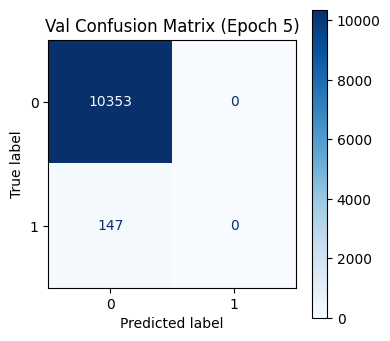

Epoch 6 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 06 | Train Loss: 0.0722, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0683, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 7 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 07 | Train Loss: 0.0700, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0703, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 8 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 08 | Train Loss: 0.0692, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0676, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 9 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 09 | Train Loss: 0.0685, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0680, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 10 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.0684, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0670, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


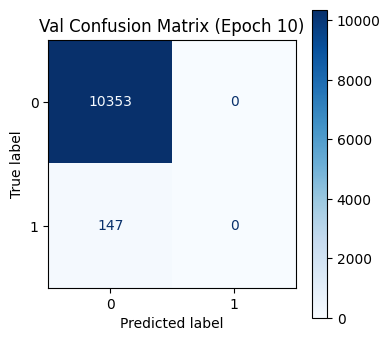

Epoch 11 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 11 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.0682, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0676, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 12 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 12 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.0678, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0666, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 13 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 13 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.0671, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0667, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 14 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 14 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.0672, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0662, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 15 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 15 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.0667, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0665, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


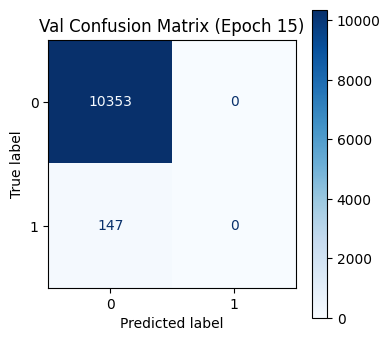

Epoch 16 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 16 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.0663, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0657, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 17 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 17 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.0659, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0653, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 18 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 18 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.0656, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0644, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 19 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 19 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.0644, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0643, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 20 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 20 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.0643, Acc: 0.9852, Prec: 0.6000, Rec: 0.0022, F1: 0.0043 | Val   Loss: 0.0644, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


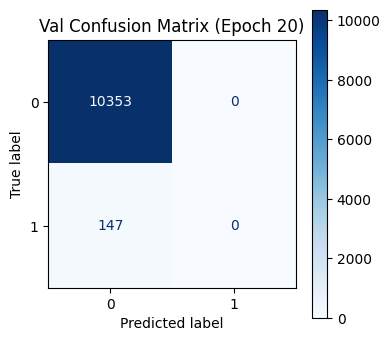

Epoch 21 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 21 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.0635, Acc: 0.9852, Prec: 0.5000, Rec: 0.0014, F1: 0.0029 | Val   Loss: 0.0633, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 22 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 22 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.0626, Acc: 0.9852, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 | Val   Loss: 0.0619, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 23 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 23 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.0621, Acc: 0.9852, Prec: 0.4000, Rec: 0.0014, F1: 0.0029 | Val   Loss: 0.0633, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 24 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 24 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.0620, Acc: 0.9852, Prec: 0.7500, Rec: 0.0022, F1: 0.0043 | Val   Loss: 0.0626, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 25 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 25 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.0601, Acc: 0.9852, Prec: 1.0000, Rec: 0.0029, F1: 0.0058 | Val   Loss: 0.0622, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


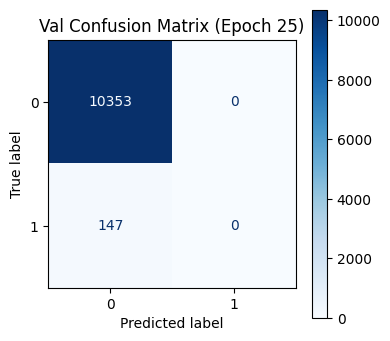

Epoch 26 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 26 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.0592, Acc: 0.9852, Prec: 0.5333, Rec: 0.0058, F1: 0.0115 | Val   Loss: 0.0609, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 27 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 27 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.0592, Acc: 0.9852, Prec: 0.4444, Rec: 0.0029, F1: 0.0058 | Val   Loss: 0.0608, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 28 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 28 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.0578, Acc: 0.9852, Prec: 0.6250, Rec: 0.0109, F1: 0.0213 | Val   Loss: 0.0637, Acc: 0.9860, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


Epoch 29 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 29 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.0559, Acc: 0.9855, Prec: 0.7377, Rec: 0.0326, F1: 0.0624 | Val   Loss: 0.0605, Acc: 0.9861, Prec: 1.0000, Rec: 0.0068, F1: 0.0135
→ Saved new best model (Val F1: 0.0135)


Epoch 30 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 30 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.0556, Acc: 0.9854, Prec: 0.7400, Rec: 0.0268, F1: 0.0517 | Val   Loss: 0.0580, Acc: 0.9861, Prec: 0.6000, Rec: 0.0204, F1: 0.0395
→ Saved new best model (Val F1: 0.0395)


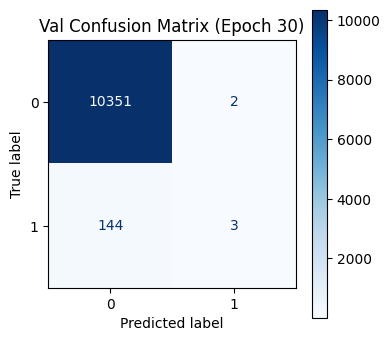

Epoch 31 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 31 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.0533, Acc: 0.9855, Prec: 0.6703, Rec: 0.0441, F1: 0.0828 | Val   Loss: 0.0565, Acc: 0.9861, Prec: 0.6667, Rec: 0.0136, F1: 0.0267


Epoch 32 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 32 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.0515, Acc: 0.9857, Prec: 0.6905, Rec: 0.0630, F1: 0.1154 | Val   Loss: 0.0587, Acc: 0.9858, Prec: 0.3750, Rec: 0.0204, F1: 0.0387


Epoch 33 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 33 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 0.0497, Acc: 0.9858, Prec: 0.6566, Rec: 0.0941, F1: 0.1646 | Val   Loss: 0.0565, Acc: 0.9860, Prec: 0.5000, Rec: 0.0272, F1: 0.0516
→ Saved new best model (Val F1: 0.0516)


Epoch 34 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 34 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.0474, Acc: 0.9861, Prec: 0.6616, Rec: 0.1259, F1: 0.2116 | Val   Loss: 0.0573, Acc: 0.9859, Prec: 0.4000, Rec: 0.0136, F1: 0.0263


Epoch 35 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 35 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 0.0452, Acc: 0.9865, Prec: 0.7055, Rec: 0.1577, F1: 0.2578 | Val   Loss: 0.0569, Acc: 0.9852, Prec: 0.3947, Rec: 0.1020, F1: 0.1622
→ Saved new best model (Val F1: 0.1622)


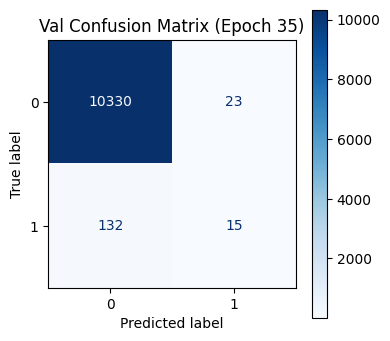

Epoch 36 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 36 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36 | Train Loss: 0.0437, Acc: 0.9864, Prec: 0.6543, Rec: 0.1780, F1: 0.2799 | Val   Loss: 0.0565, Acc: 0.9857, Prec: 0.4000, Rec: 0.0408, F1: 0.0741


Epoch 37 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 37 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.0412, Acc: 0.9872, Prec: 0.7093, Rec: 0.2330, F1: 0.3508 | Val   Loss: 0.0503, Acc: 0.9862, Prec: 0.5714, Rec: 0.0544, F1: 0.0994


Epoch 38 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 38 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38 | Train Loss: 0.0381, Acc: 0.9876, Prec: 0.7091, Rec: 0.2822, F1: 0.4037 | Val   Loss: 0.0527, Acc: 0.9856, Prec: 0.4630, Rec: 0.1701, F1: 0.2488
→ Saved new best model (Val F1: 0.2488)


Epoch 39 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 39 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39 | Train Loss: 0.0367, Acc: 0.9881, Prec: 0.7226, Rec: 0.3242, F1: 0.4476 | Val   Loss: 0.0539, Acc: 0.9849, Prec: 0.4231, Rec: 0.2245, F1: 0.2933
→ Saved new best model (Val F1: 0.2933)


Epoch 40 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 40 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40 | Train Loss: 0.0349, Acc: 0.9886, Prec: 0.7391, Rec: 0.3546, F1: 0.4792 | Val   Loss: 0.0520, Acc: 0.9860, Prec: 0.5000, Rec: 0.1020, F1: 0.1695


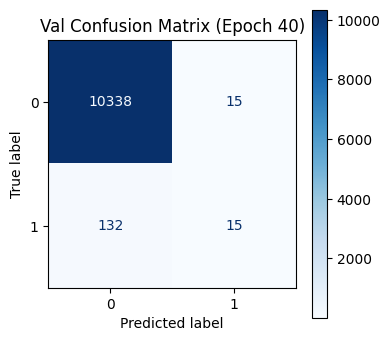

Epoch 41 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 41 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 41 | Train Loss: 0.0299, Acc: 0.9898, Prec: 0.7628, Rec: 0.4515, F1: 0.5673 | Val   Loss: 0.0454, Acc: 0.9871, Prec: 0.5968, Rec: 0.2517, F1: 0.3541
→ Saved new best model (Val F1: 0.3541)


Epoch 42 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 42 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 0.0271, Acc: 0.9911, Prec: 0.7918, Rec: 0.5449, F1: 0.6455 | Val   Loss: 0.0504, Acc: 0.9873, Prec: 0.6400, Rec: 0.2177, F1: 0.3249


Epoch 43 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 43 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 0.0252, Acc: 0.9915, Prec: 0.7950, Rec: 0.5753, F1: 0.6675 | Val   Loss: 0.0479, Acc: 0.9850, Prec: 0.4432, Rec: 0.2653, F1: 0.3319


Epoch 44 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 44 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 0.0213, Acc: 0.9926, Prec: 0.8264, Rec: 0.6339, F1: 0.7174 | Val   Loss: 0.0454, Acc: 0.9859, Prec: 0.4947, Rec: 0.3197, F1: 0.3884
→ Saved new best model (Val F1: 0.3884)


Epoch 45 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 45 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 45 | Train Loss: 0.0206, Acc: 0.9927, Prec: 0.8154, Rec: 0.6520, F1: 0.7246 | Val   Loss: 0.0470, Acc: 0.9871, Prec: 0.5811, Rec: 0.2925, F1: 0.3891
→ Saved new best model (Val F1: 0.3891)


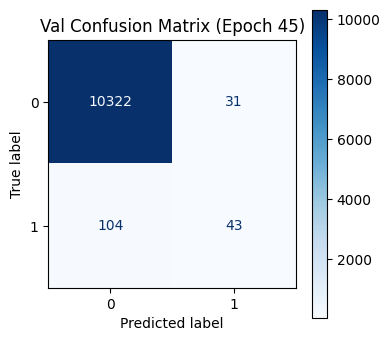

Epoch 46 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 46 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 46 | Train Loss: 0.0186, Acc: 0.9931, Prec: 0.8172, Rec: 0.6889, F1: 0.7475 | Val   Loss: 0.0421, Acc: 0.9890, Prec: 0.7162, Rec: 0.3605, F1: 0.4796
→ Saved new best model (Val F1: 0.4796)


Epoch 47 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 47 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 47 | Train Loss: 0.0160, Acc: 0.9941, Prec: 0.8402, Rec: 0.7417, F1: 0.7879 | Val   Loss: 0.0470, Acc: 0.9847, Prec: 0.4435, Rec: 0.3741, F1: 0.4059


Epoch 48 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 48 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 48 | Train Loss: 0.0159, Acc: 0.9941, Prec: 0.8438, Rec: 0.7388, F1: 0.7878 | Val   Loss: 0.0437, Acc: 0.9887, Prec: 0.6667, Rec: 0.3810, F1: 0.4848
→ Saved new best model (Val F1: 0.4848)


Epoch 49 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 49 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 49 | Train Loss: 0.0123, Acc: 0.9956, Prec: 0.8764, Rec: 0.8213, F1: 0.8480 | Val   Loss: 0.0451, Acc: 0.9886, Prec: 0.6552, Rec: 0.3878, F1: 0.4872
→ Saved new best model (Val F1: 0.4872)


Epoch 50 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 50 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 50 | Train Loss: 0.0120, Acc: 0.9958, Prec: 0.8881, Rec: 0.8213, F1: 0.8534 | Val   Loss: 0.0519, Acc: 0.9866, Prec: 0.5326, Rec: 0.3333, F1: 0.4100


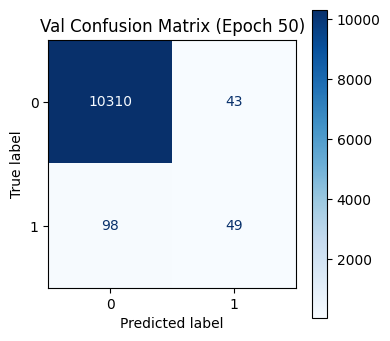

Epoch 51 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 51 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 51 | Train Loss: 0.0114, Acc: 0.9959, Prec: 0.8923, Rec: 0.8213, F1: 0.8553 | Val   Loss: 0.0464, Acc: 0.9888, Prec: 0.6883, Rec: 0.3605, F1: 0.4732


Epoch 52 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 52 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 52 | Train Loss: 0.0084, Acc: 0.9971, Prec: 0.9224, Rec: 0.8777, F1: 0.8995 | Val   Loss: 0.0444, Acc: 0.9886, Prec: 0.6392, Rec: 0.4218, F1: 0.5082
→ Saved new best model (Val F1: 0.5082)


Epoch 53 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 53 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 53 | Train Loss: 0.0084, Acc: 0.9971, Prec: 0.9167, Rec: 0.8835, F1: 0.8998 | Val   Loss: 0.0430, Acc: 0.9896, Prec: 0.6583, Rec: 0.5374, F1: 0.5918
→ Saved new best model (Val F1: 0.5918)


Epoch 54 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 54 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 54 | Train Loss: 0.0066, Acc: 0.9978, Prec: 0.9420, Rec: 0.9052, F1: 0.9232 | Val   Loss: 0.0437, Acc: 0.9902, Prec: 0.7000, Rec: 0.5238, F1: 0.5992
→ Saved new best model (Val F1: 0.5992)


Epoch 55 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 55 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 55 | Train Loss: 0.0076, Acc: 0.9973, Prec: 0.9190, Rec: 0.8944, F1: 0.9065 | Val   Loss: 0.0452, Acc: 0.9887, Prec: 0.6429, Rec: 0.4286, F1: 0.5143


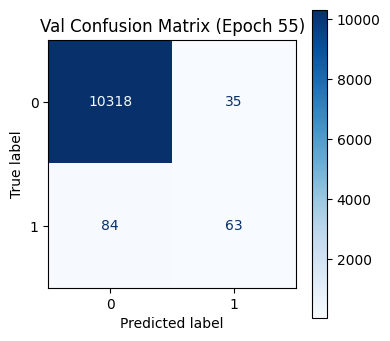

Epoch 56 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 56 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 56 | Train Loss: 0.0074, Acc: 0.9974, Prec: 0.9266, Rec: 0.8958, F1: 0.9110 | Val   Loss: 0.0404, Acc: 0.9889, Prec: 0.6071, Rec: 0.5782, F1: 0.5923


Epoch 57 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 57 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 57 | Train Loss: 0.0067, Acc: 0.9976, Prec: 0.9294, Rec: 0.9052, F1: 0.9172 | Val   Loss: 0.0509, Acc: 0.9888, Prec: 0.7302, Rec: 0.3129, F1: 0.4381


Epoch 58 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 58 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 58 | Train Loss: 0.0085, Acc: 0.9971, Prec: 0.9115, Rec: 0.8871, F1: 0.8992 | Val   Loss: 0.0483, Acc: 0.9890, Prec: 0.6505, Rec: 0.4558, F1: 0.5360


Epoch 59 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 59 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 59 | Train Loss: 0.0073, Acc: 0.9974, Prec: 0.9247, Rec: 0.8980, F1: 0.9112 | Val   Loss: 0.0447, Acc: 0.9870, Prec: 0.5316, Rec: 0.5714, F1: 0.5508


Epoch 60 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 60 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 60 | Train Loss: 0.0059, Acc: 0.9981, Prec: 0.9426, Rec: 0.9276, F1: 0.9351 | Val   Loss: 0.0516, Acc: 0.9896, Prec: 0.7209, Rec: 0.4218, F1: 0.5322


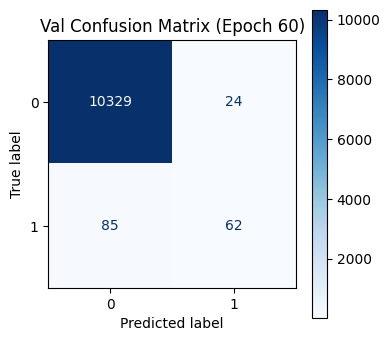

Epoch 61 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 61 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 61 | Train Loss: 0.0055, Acc: 0.9979, Prec: 0.9362, Rec: 0.9240, F1: 0.9301 | Val   Loss: 0.0466, Acc: 0.9905, Prec: 0.7423, Rec: 0.4898, F1: 0.5902


Epoch 62 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 62 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 62 | Train Loss: 0.0049, Acc: 0.9983, Prec: 0.9486, Rec: 0.9356, F1: 0.9421 | Val   Loss: 0.0520, Acc: 0.9876, Prec: 0.5639, Rec: 0.5102, F1: 0.5357


Epoch 63 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 63 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 63 | Train Loss: 0.0045, Acc: 0.9985, Prec: 0.9587, Rec: 0.9414, F1: 0.9500 | Val   Loss: 0.0433, Acc: 0.9893, Prec: 0.6522, Rec: 0.5102, F1: 0.5725


Epoch 64 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 64 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 64 | Train Loss: 0.0027, Acc: 0.9991, Prec: 0.9696, Rec: 0.9689, F1: 0.9692 | Val   Loss: 0.0455, Acc: 0.9883, Prec: 0.6071, Rec: 0.4626, F1: 0.5251


Epoch 65 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 65 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 65 | Train Loss: 0.0078, Acc: 0.9972, Prec: 0.9106, Rec: 0.8994, F1: 0.9050 | Val   Loss: 0.0452, Acc: 0.9887, Prec: 0.6667, Rec: 0.3810, F1: 0.4848


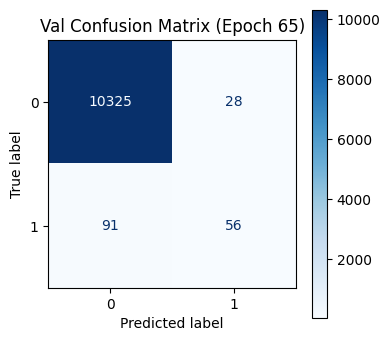

Epoch 66 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 66 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 66 | Train Loss: 0.0048, Acc: 0.9983, Prec: 0.9433, Rec: 0.9392, F1: 0.9413 | Val   Loss: 0.0493, Acc: 0.9896, Prec: 0.7714, Rec: 0.3673, F1: 0.4977


Epoch 67 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 67 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 67 | Train Loss: 0.0045, Acc: 0.9984, Prec: 0.9524, Rec: 0.9407, F1: 0.9465 | Val   Loss: 0.0428, Acc: 0.9907, Prec: 0.7248, Rec: 0.5374, F1: 0.6172
→ Saved new best model (Val F1: 0.6172)


Epoch 68 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 68 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 68 | Train Loss: 0.0035, Acc: 0.9990, Prec: 0.9722, Rec: 0.9631, F1: 0.9676 | Val   Loss: 0.0417, Acc: 0.9903, Prec: 0.7064, Rec: 0.5238, F1: 0.6016


Epoch 69 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 69 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 69 | Train Loss: 0.0051, Acc: 0.9982, Prec: 0.9443, Rec: 0.9327, F1: 0.9385 | Val   Loss: 0.0414, Acc: 0.9910, Prec: 0.7345, Rec: 0.5646, F1: 0.6385
→ Saved new best model (Val F1: 0.6385)


Epoch 70 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 70 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 70 | Train Loss: 0.0036, Acc: 0.9987, Prec: 0.9620, Rec: 0.9515, F1: 0.9567 | Val   Loss: 0.0420, Acc: 0.9905, Prec: 0.7196, Rec: 0.5238, F1: 0.6063


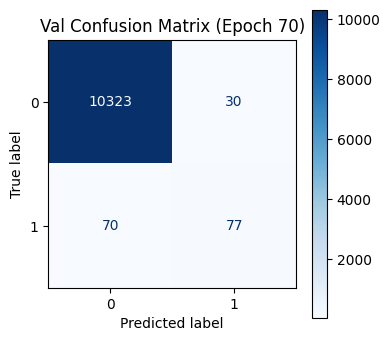

Epoch 71 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 71 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 71 | Train Loss: 0.0052, Acc: 0.9982, Prec: 0.9471, Rec: 0.9320, F1: 0.9395 | Val   Loss: 0.0428, Acc: 0.9907, Prec: 0.7025, Rec: 0.5782, F1: 0.6343


Epoch 72 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 72 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 72 | Train Loss: 0.0018, Acc: 0.9995, Prec: 0.9812, Rec: 0.9819, F1: 0.9816 | Val   Loss: 0.0404, Acc: 0.9918, Prec: 0.7748, Rec: 0.5850, F1: 0.6667
→ Saved new best model (Val F1: 0.6667)


Epoch 73 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 73 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 73 | Train Loss: 0.0013, Acc: 0.9995, Prec: 0.9855, Rec: 0.9841, F1: 0.9848 | Val   Loss: 0.0459, Acc: 0.9907, Prec: 0.7168, Rec: 0.5510, F1: 0.6231


Epoch 74 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 74 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 74 | Train Loss: 0.0014, Acc: 0.9995, Prec: 0.9841, Rec: 0.9848, F1: 0.9844 | Val   Loss: 0.0489, Acc: 0.9902, Prec: 0.6897, Rec: 0.5442, F1: 0.6084


Epoch 75 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 75 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 75 | Train Loss: 0.0035, Acc: 0.9987, Prec: 0.9580, Rec: 0.9566, F1: 0.9573 | Val   Loss: 0.0424, Acc: 0.9895, Prec: 0.6529, Rec: 0.5374, F1: 0.5896


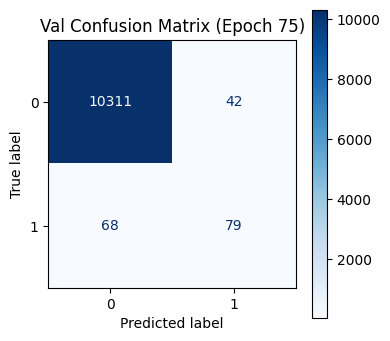

Epoch 76 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 76 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 76 | Train Loss: 0.0054, Acc: 0.9982, Prec: 0.9430, Rec: 0.9342, F1: 0.9386 | Val   Loss: 0.0450, Acc: 0.9900, Prec: 0.6842, Rec: 0.5306, F1: 0.5977


Epoch 77 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 77 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 77 | Train Loss: 0.0030, Acc: 0.9992, Prec: 0.9759, Rec: 0.9689, F1: 0.9724 | Val   Loss: 0.0436, Acc: 0.9910, Prec: 0.7624, Rec: 0.5238, F1: 0.6210


Epoch 78 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 78 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 78 | Train Loss: 0.0017, Acc: 0.9995, Prec: 0.9826, Rec: 0.9826, F1: 0.9826 | Val   Loss: 0.0425, Acc: 0.9904, Prec: 0.6742, Rec: 0.6054, F1: 0.6380


Epoch 79 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 79 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 79 | Train Loss: 0.0023, Acc: 0.9992, Prec: 0.9712, Rec: 0.9754, F1: 0.9733 | Val   Loss: 0.0477, Acc: 0.9910, Prec: 0.7653, Rec: 0.5102, F1: 0.6122


Epoch 80 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 80 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 80 | Train Loss: 0.0016, Acc: 0.9994, Prec: 0.9791, Rec: 0.9819, F1: 0.9805 | Val   Loss: 0.0437, Acc: 0.9907, Prec: 0.7753, Rec: 0.4694, F1: 0.5847


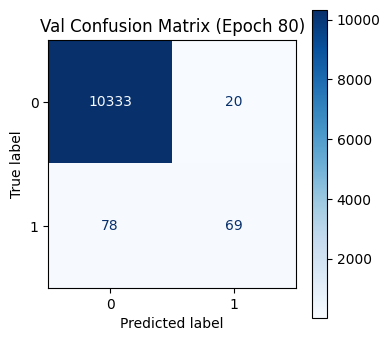

Epoch 81 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 81 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 81 | Train Loss: 0.0054, Acc: 0.9981, Prec: 0.9389, Rec: 0.9342, F1: 0.9365 | Val   Loss: 0.0526, Acc: 0.9872, Prec: 0.5504, Rec: 0.4830, F1: 0.5145


Epoch 82 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 82 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 82 | Train Loss: 0.0051, Acc: 0.9983, Prec: 0.9486, Rec: 0.9349, F1: 0.9417 | Val   Loss: 0.0485, Acc: 0.9909, Prec: 0.7802, Rec: 0.4830, F1: 0.5966


Epoch 83 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 83 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 83 | Train Loss: 0.0020, Acc: 0.9993, Prec: 0.9789, Rec: 0.9740, F1: 0.9764 | Val   Loss: 0.0456, Acc: 0.9903, Prec: 0.6860, Rec: 0.5646, F1: 0.6194


Epoch 84 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 84 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 84 | Train Loss: 0.0011, Acc: 0.9997, Prec: 0.9870, Rec: 0.9913, F1: 0.9892 | Val   Loss: 0.0498, Acc: 0.9912, Prec: 0.8161, Rec: 0.4830, F1: 0.6068


Epoch 85 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 85 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 85 | Train Loss: 0.0007, Acc: 0.9998, Prec: 0.9928, Rec: 0.9949, F1: 0.9939 | Val   Loss: 0.0488, Acc: 0.9904, Prec: 0.7255, Rec: 0.5034, F1: 0.5944


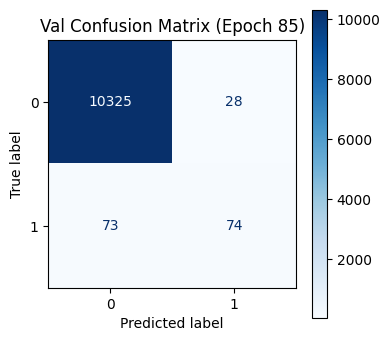

Epoch 86 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 86 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 86 | Train Loss: 0.0009, Acc: 0.9998, Prec: 0.9928, Rec: 0.9920, F1: 0.9924 | Val   Loss: 0.0557, Acc: 0.9897, Prec: 0.6931, Rec: 0.4762, F1: 0.5645


Epoch 87 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 87 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 87 | Train Loss: 0.0006, Acc: 0.9998, Prec: 0.9949, Rec: 0.9942, F1: 0.9946 | Val   Loss: 0.0445, Acc: 0.9925, Prec: 0.8617, Rec: 0.5510, F1: 0.6722
→ Saved new best model (Val F1: 0.6722)


Epoch 88 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 88 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 88 | Train Loss: 0.0051, Acc: 0.9983, Prec: 0.9433, Rec: 0.9392, F1: 0.9413 | Val   Loss: 0.0468, Acc: 0.9897, Prec: 0.6757, Rec: 0.5102, F1: 0.5814


Epoch 89 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 89 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 89 | Train Loss: 0.0077, Acc: 0.9973, Prec: 0.9194, Rec: 0.8994, F1: 0.9093 | Val   Loss: 0.0389, Acc: 0.9910, Prec: 0.7167, Rec: 0.5850, F1: 0.6442


Epoch 90 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 90 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 90 | Train Loss: 0.0019, Acc: 0.9994, Prec: 0.9833, Rec: 0.9783, F1: 0.9808 | Val   Loss: 0.0386, Acc: 0.9926, Prec: 0.8286, Rec: 0.5918, F1: 0.6905
→ Saved new best model (Val F1: 0.6905)


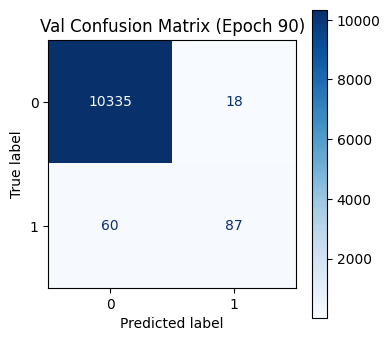

Epoch 91 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 91 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 91 | Train Loss: 0.0005, Acc: 0.9999, Prec: 0.9971, Rec: 0.9964, F1: 0.9967 | Val   Loss: 0.0375, Acc: 0.9929, Prec: 0.8158, Rec: 0.6327, F1: 0.7126
→ Saved new best model (Val F1: 0.7126)


Epoch 92 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 92 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 92 | Train Loss: 0.0007, Acc: 0.9998, Prec: 0.9928, Rec: 0.9935, F1: 0.9931 | Val   Loss: 0.0402, Acc: 0.9929, Prec: 0.8158, Rec: 0.6327, F1: 0.7126


Epoch 93 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 93 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 93 | Train Loss: 0.0005, Acc: 0.9998, Prec: 0.9956, Rec: 0.9928, F1: 0.9942 | Val   Loss: 0.0423, Acc: 0.9923, Prec: 0.8438, Rec: 0.5510, F1: 0.6667


Epoch 94 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 94 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 94 | Train Loss: 0.0019, Acc: 0.9994, Prec: 0.9811, Rec: 0.9768, F1: 0.9790 | Val   Loss: 0.0576, Acc: 0.9892, Prec: 0.6700, Rec: 0.4558, F1: 0.5425


Epoch 95 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 95 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 95 | Train Loss: 0.0075, Acc: 0.9974, Prec: 0.9185, Rec: 0.9052, F1: 0.9118 | Val   Loss: 0.0441, Acc: 0.9894, Prec: 0.6698, Rec: 0.4830, F1: 0.5613


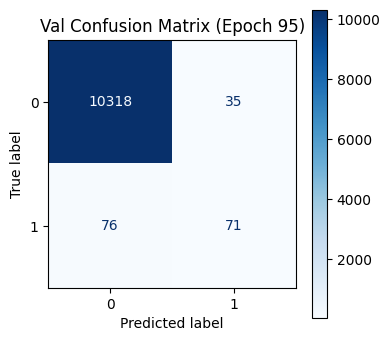

Epoch 96 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 96 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 96 | Train Loss: 0.0018, Acc: 0.9994, Prec: 0.9811, Rec: 0.9776, F1: 0.9793 | Val   Loss: 0.0403, Acc: 0.9916, Prec: 0.7757, Rec: 0.5646, F1: 0.6535


Epoch 97 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 97 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 97 | Train Loss: 0.0009, Acc: 0.9998, Prec: 0.9906, Rec: 0.9928, F1: 0.9917 | Val   Loss: 0.0452, Acc: 0.9921, Prec: 0.8019, Rec: 0.5782, F1: 0.6719


Epoch 98 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 98 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 98 | Train Loss: 0.0014, Acc: 0.9996, Prec: 0.9855, Rec: 0.9848, F1: 0.9852 | Val   Loss: 0.0488, Acc: 0.9914, Prec: 0.8202, Rec: 0.4966, F1: 0.6186


Epoch 99 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 99 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 99 | Train Loss: 0.0018, Acc: 0.9994, Prec: 0.9819, Rec: 0.9797, F1: 0.9808 | Val   Loss: 0.0441, Acc: 0.9906, Prec: 0.7791, Rec: 0.4558, F1: 0.5751


Epoch 100 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 100 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 100 | Train Loss: 0.0036, Acc: 0.9988, Prec: 0.9628, Rec: 0.9551, F1: 0.9590 | Val   Loss: 0.0541, Acc: 0.9891, Prec: 0.6542, Rec: 0.4762, F1: 0.5512


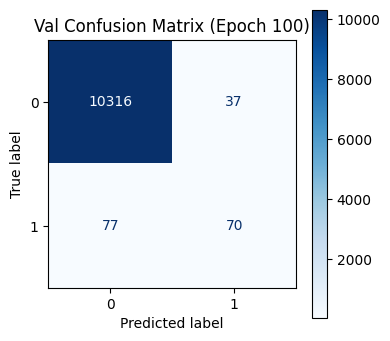

Epoch 101 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 101 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 101 | Train Loss: 0.0053, Acc: 0.9983, Prec: 0.9459, Rec: 0.9363, F1: 0.9411 | Val   Loss: 0.0414, Acc: 0.9902, Prec: 0.7444, Rec: 0.4558, F1: 0.5654


Epoch 102 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 102 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 102 | Train Loss: 0.0020, Acc: 0.9994, Prec: 0.9811, Rec: 0.9761, F1: 0.9786 | Val   Loss: 0.0361, Acc: 0.9920, Prec: 0.7944, Rec: 0.5782, F1: 0.6693


Epoch 103 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 103 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 103 | Train Loss: 0.0009, Acc: 0.9997, Prec: 0.9920, Rec: 0.9891, F1: 0.9906 | Val   Loss: 0.0425, Acc: 0.9923, Prec: 0.8837, Rec: 0.5170, F1: 0.6524


Epoch 104 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 104 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 104 | Train Loss: 0.0004, Acc: 0.9999, Prec: 0.9964, Rec: 0.9949, F1: 0.9957 | Val   Loss: 0.0388, Acc: 0.9930, Prec: 0.8614, Rec: 0.5918, F1: 0.7016


Epoch 105 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 105 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 105 | Train Loss: 0.0006, Acc: 0.9998, Prec: 0.9964, Rec: 0.9935, F1: 0.9949 | Val   Loss: 0.0421, Acc: 0.9912, Prec: 0.7068, Rec: 0.6395, F1: 0.6714


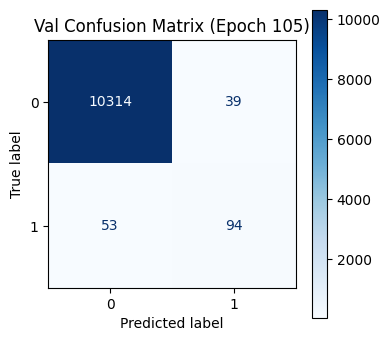

Epoch 106 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 106 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 106 | Train Loss: 0.0004, Acc: 0.9999, Prec: 0.9949, Rec: 0.9978, F1: 0.9964 | Val   Loss: 0.0414, Acc: 0.9931, Prec: 0.8713, Rec: 0.5986, F1: 0.7097


Epoch 107 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 107 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 107 | Train Loss: 0.0005, Acc: 0.9998, Prec: 0.9949, Rec: 0.9949, F1: 0.9949 | Val   Loss: 0.0513, Acc: 0.9912, Prec: 0.8090, Rec: 0.4898, F1: 0.6102


Epoch 108 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 108 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 108 | Train Loss: 0.0051, Acc: 0.9985, Prec: 0.9499, Rec: 0.9457, F1: 0.9478 | Val   Loss: 0.0452, Acc: 0.9915, Prec: 0.7843, Rec: 0.5442, F1: 0.6426


Epoch 109 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 109 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 109 | Train Loss: 0.0037, Acc: 0.9987, Prec: 0.9620, Rec: 0.9522, F1: 0.9571 | Val   Loss: 0.0390, Acc: 0.9921, Prec: 0.8077, Rec: 0.5714, F1: 0.6693


Epoch 110 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 110 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 110 | Train Loss: 0.0017, Acc: 0.9994, Prec: 0.9805, Rec: 0.9819, F1: 0.9812 | Val   Loss: 0.0481, Acc: 0.9912, Prec: 0.8161, Rec: 0.4830, F1: 0.6068


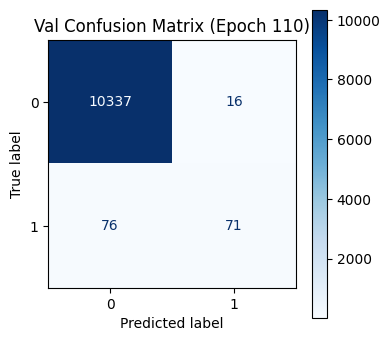

Epoch 111 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 111 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 111 | Train Loss: 0.0035, Acc: 0.9989, Prec: 0.9664, Rec: 0.9580, F1: 0.9622 | Val   Loss: 0.0381, Acc: 0.9916, Prec: 0.8315, Rec: 0.5034, F1: 0.6271


Epoch 112 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 112 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 112 | Train Loss: 0.0014, Acc: 0.9995, Prec: 0.9841, Rec: 0.9826, F1: 0.9833 | Val   Loss: 0.0435, Acc: 0.9924, Prec: 0.8681, Rec: 0.5374, F1: 0.6639


Epoch 113 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 113 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 113 | Train Loss: 0.0008, Acc: 0.9998, Prec: 0.9935, Rec: 0.9920, F1: 0.9928 | Val   Loss: 0.0411, Acc: 0.9910, Prec: 0.7054, Rec: 0.6190, F1: 0.6594


Epoch 114 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 114 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 114 | Train Loss: 0.0002, Acc: 0.9999, Prec: 0.9971, Rec: 0.9993, F1: 0.9982 | Val   Loss: 0.0448, Acc: 0.9914, Prec: 0.7664, Rec: 0.5578, F1: 0.6457


Epoch 115 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 115 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 115 | Train Loss: 0.0005, Acc: 0.9999, Prec: 0.9942, Rec: 0.9978, F1: 0.9960 | Val   Loss: 0.0469, Acc: 0.9919, Prec: 0.8780, Rec: 0.4898, F1: 0.6288


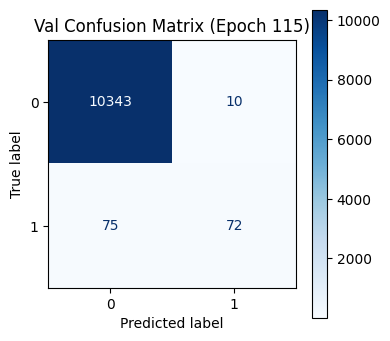

Epoch 116 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 116 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 116 | Train Loss: 0.0020, Acc: 0.9994, Prec: 0.9769, Rec: 0.9812, F1: 0.9791 | Val   Loss: 0.0520, Acc: 0.9901, Prec: 0.7129, Rec: 0.4898, F1: 0.5806


Epoch 117 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 117 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 117 | Train Loss: 0.0056, Acc: 0.9981, Prec: 0.9380, Rec: 0.9313, F1: 0.9346 | Val   Loss: 0.0380, Acc: 0.9917, Prec: 0.7830, Rec: 0.5646, F1: 0.6561


Epoch 118 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 118 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 118 | Train Loss: 0.0023, Acc: 0.9992, Prec: 0.9753, Rec: 0.9696, F1: 0.9724 | Val   Loss: 0.0443, Acc: 0.9918, Prec: 0.7961, Rec: 0.5578, F1: 0.6560


Epoch 119 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 119 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 119 | Train Loss: 0.0008, Acc: 0.9998, Prec: 0.9920, Rec: 0.9913, F1: 0.9917 | Val   Loss: 0.0430, Acc: 0.9930, Prec: 0.8614, Rec: 0.5918, F1: 0.7016


Epoch 120 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 120 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 120 | Train Loss: 0.0009, Acc: 0.9997, Prec: 0.9906, Rec: 0.9906, F1: 0.9906 | Val   Loss: 0.0418, Acc: 0.9926, Prec: 0.8000, Rec: 0.6259, F1: 0.7023


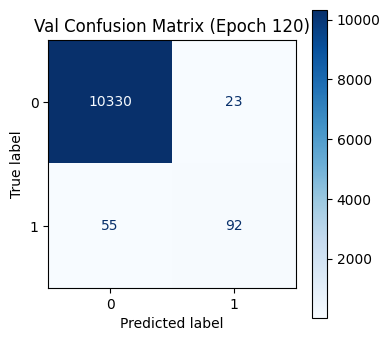

Epoch 121 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 121 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 121 | Train Loss: 0.0021, Acc: 0.9993, Prec: 0.9789, Rec: 0.9754, F1: 0.9772 | Val   Loss: 0.0485, Acc: 0.9918, Prec: 0.8427, Rec: 0.5102, F1: 0.6356


Epoch 122 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 122 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 122 | Train Loss: 0.0021, Acc: 0.9993, Prec: 0.9810, Rec: 0.9732, F1: 0.9771 | Val   Loss: 0.0373, Acc: 0.9927, Prec: 0.8365, Rec: 0.5918, F1: 0.6932


Epoch 123 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 123 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 123 | Train Loss: 0.0008, Acc: 0.9998, Prec: 0.9913, Rec: 0.9935, F1: 0.9924 | Val   Loss: 0.0345, Acc: 0.9935, Prec: 0.8835, Rec: 0.6190, F1: 0.7280
→ Saved new best model (Val F1: 0.7280)


Epoch 124 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 124 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 124 | Train Loss: 0.0004, Acc: 0.9999, Prec: 0.9942, Rec: 0.9971, F1: 0.9957 | Val   Loss: 0.0419, Acc: 0.9929, Prec: 0.8600, Rec: 0.5850, F1: 0.6964


Epoch 125 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 125 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 125 | Train Loss: 0.0028, Acc: 0.9992, Prec: 0.9732, Rec: 0.9732, F1: 0.9732 | Val   Loss: 0.0542, Acc: 0.9891, Prec: 0.6737, Rec: 0.4354, F1: 0.5289


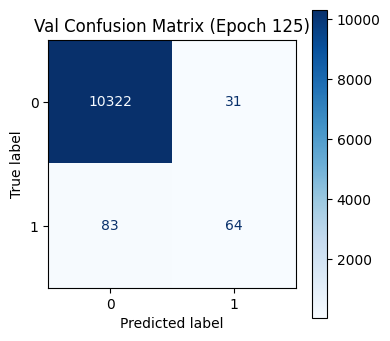

Epoch 126 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 126 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 126 | Train Loss: 0.0059, Acc: 0.9981, Prec: 0.9422, Rec: 0.9320, F1: 0.9371 | Val   Loss: 0.0380, Acc: 0.9914, Prec: 0.7280, Rec: 0.6190, F1: 0.6691


Epoch 127 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 127 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 127 | Train Loss: 0.0012, Acc: 0.9996, Prec: 0.9884, Rec: 0.9863, F1: 0.9873 | Val   Loss: 0.0374, Acc: 0.9917, Prec: 0.7679, Rec: 0.5850, F1: 0.6641


Epoch 128 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 128 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 128 | Train Loss: 0.0011, Acc: 0.9996, Prec: 0.9877, Rec: 0.9877, F1: 0.9877 | Val   Loss: 0.0420, Acc: 0.9923, Prec: 0.8667, Rec: 0.5306, F1: 0.6582


Epoch 129 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 129 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 129 | Train Loss: 0.0008, Acc: 0.9998, Prec: 0.9942, Rec: 0.9935, F1: 0.9938 | Val   Loss: 0.0391, Acc: 0.9926, Prec: 0.8710, Rec: 0.5510, F1: 0.6750


Epoch 130 Train:   0%|          | 0/84 [00:00<?, ?it/s]

Epoch 130 Val:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 130 | Train Loss: 0.0002, Acc: 1.0000, Prec: 0.9993, Rec: 0.9993, F1: 0.9993 | Val   Loss: 0.0431, Acc: 0.9928, Prec: 0.9383, Rec: 0.5170, F1: 0.6667


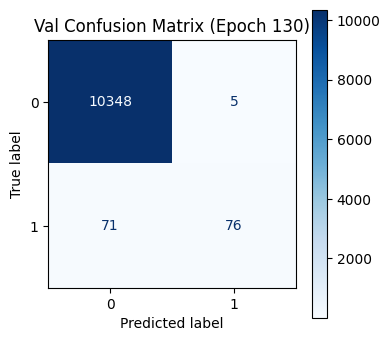

In [5]:
# Cell 4: Training Loop with Acc/Prec/Rec/F1 and Confusion Matrix
EPOCHS= 130

from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

best_val_f1 = 0.0

for epoch in range(1, EPOCHS + 1):
    # ——— Training ———
    model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_targets = []

    loop = tqdm(train_loader, desc=f"Epoch {epoch} Train", leave=False)
    for x, y, *_ in loop:
        x, y = x.to(device), y.to(device).float()

        logits = model(x)
        loss   = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long().cpu().view(-1).numpy()
        targ  = y.cpu().view(-1).numpy()

        all_train_preds.extend(preds)
        all_train_targets.extend(targ)

        loop.set_postfix(train_loss=loss.item())

    train_loss /= len(train_ds)
    train_acc  = accuracy_score(all_train_targets, all_train_preds)
    train_prec = precision_score(all_train_targets, all_train_preds, zero_division=0)
    train_rec  = recall_score(all_train_targets, all_train_preds, zero_division=0)
    train_f1   = f1_score(all_train_targets, all_train_preds, zero_division=0)

    # ——— Validation ———
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_targets = []

    loop = tqdm(val_loader, desc=f"Epoch {epoch} Val", leave=False)
    with torch.no_grad():
        for x, y, *_ in loop:
            x, y = x.to(device), y.to(device).float()
            logits = model(x)
            loss   = criterion(logits, y)
            val_loss += loss.item() * x.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long().cpu().view(-1).numpy()
            targ  = y.cpu().view(-1).numpy()

            all_val_preds.extend(preds)
            all_val_targets.extend(targ)

            loop.set_postfix(val_loss=loss.item())

    val_loss /= len(val_ds)
    val_acc  = accuracy_score(all_val_targets, all_val_preds)
    val_prec = precision_score(all_val_targets, all_val_preds, zero_division=0)
    val_rec  = recall_score(all_val_targets, all_val_preds, zero_division=0)
    val_f1   = f1_score(all_val_targets, all_val_preds, zero_division=0)

    # ——— Print Metrics ———
    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f} | "
        f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, Rec: {val_rec:.4f}, F1: {val_f1:.4f}"
    )

    # ——— Save Best ———
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_patch_timesformer_v2_by_f1_6.pt")
        print(f"→ Saved new best model (Val F1: {val_f1:.4f})")

    # ——— Confusion Matrix Every 5 Epochs ———
    if epoch % 5 == 0 or epoch == EPOCHS:
        cm = confusion_matrix(all_val_targets, all_val_preds, labels=[0,1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        fig, ax = plt.subplots(figsize=(4,4))
        disp.plot(ax=ax, cmap='Blues', values_format='d')
        ax.set_title(f"Val Confusion Matrix (Epoch {epoch})")
        plt.show()

In [5]:
# Cell X: Compute & Save Per-Channel Saliency Maps (Patch-specific + Global) over Entire Validation Set

import os
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.ndimage import gaussian_filter

# --- Channel names ---
channel_names = [
    "500 Saturation Deficit",
    "Surface radiation",
    "500 cloud cover",
    "500 Vorticity (relative)",
    "850 Vorticity (relative)",
    "Potential Intensity",
    "850 Specific humidity",
    "Vertical Shear",
    "OHC",
]

# 1) Load & prep model
model = RevisedHierarchicalPatchTimesformer(
    seq_len=SEQ_LEN, in_ch=IN_CH,
    H=40, W=100,
    small_patch_h=2, small_patch_w=2,
    patch_h=20, patch_w=20,
    embed_small=64, depth_small=2,
    embed_large=128, depth_large=4,
    num_heads=8
).to(device)
model.load_state_dict(torch.load("best_patch_timesformer_v2_by_f1_6.pt", map_location=device))
model.eval()

# 2) IG parameters
steps = 20
alphas = torch.linspace(0.0, 1.0, steps, device=device)
factor = 2  # down-sample factor

# 3) Geographic bounds
n_lat_full, n_lon_full = 90, 180
region_lat0, region_lon0 = 45, 80
# retrieve H,W from one batch
sample_x, _, _, _ = next(iter(val_loader))
H, W = sample_x.shape[-2:]
lat_max =  90.0 - (region_lat0 + 0.5) * (90.0 / n_lat_full)
lat_min =  90.0 - (region_lat0 + H   - 0.5) * (90.0 / n_lat_full)
lon_min = -180.0 + (region_lon0 + 0.5) * (180.0 / n_lon_full)
lon_max = -180.0 + (region_lon0 + W   - 0.5) * (180.0 / n_lon_full)

# 4) Build coarse grid
n_lat_c = H // factor
n_lon_c = W // factor
lats = np.linspace(lat_max, lat_min, n_lat_c)
lons = np.linspace(lon_min, lon_max, n_lon_c)
lon2d, lat2d = np.meshgrid(lons, lats)

# 5) Contour levels
levels = np.linspace(-1, 1, 21)

# 6) Prepare output folders
base_dir = "saliency_maps_9Channels_6"
os.makedirs(base_dir, exist_ok=True)

# determine patch dims from a forward pass
with torch.no_grad():
    _, _, n_lat, n_lon = model(sample_x[:1].to(device)).shape

# 7) Process each channel
for c, name in enumerate(channel_names):
    print(f"[Channel {c}] {name}: Computing patch-specific saliency...")
    # initialize accumulators
    patch_sum = {(i,j): np.zeros((H, W), dtype=np.float32) for i in range(n_lat) for j in range(n_lon)}
    patch_count = {(i,j): 0 for i in range(n_lat) for j in range(n_lon)}
    global_sum = np.zeros((H, W), dtype=np.float32)
    global_count = 0

    # loop over entire validation set
    for x_batch, _, _, _ in val_loader:
        B = x_batch.shape[0]
        x_batch = x_batch.to(device)                      # (B,T,C,H,W)
        baseline = torch.zeros_like(x_batch)
        diff = x_batch - baseline

        # compute global IG for batch
        total_grad = torch.zeros_like(x_batch)
        for alpha in alphas:
            inp = baseline + alpha * diff
            inp.requires_grad_(True)
            logits = model(inp)                           # (B, T, n_lat, n_lon)
            score = logits.sum(dim=(1,2,3))               # (B,)
            model.zero_grad()
            score.sum().backward()
            total_grad += inp.grad
        ig_global = diff * total_grad / steps             # (B,T,C,H,W)
        sal_global = ig_global[:,:,c,:,:].abs().mean(dim=1).cpu().numpy()  # (B,H,W)
        global_sum += sal_global.sum(axis=0)
        global_count += B

        # compute patch-specific IG for each patch in this batch
        for i in range(n_lat):
            for j in range(n_lon):
                total_grad_p = torch.zeros_like(x_batch)
                for alpha in alphas:
                    inp = baseline + alpha * diff
                    inp.requires_grad_(True)
                    out = model(inp)[:,:,i,j].sum(dim=(1,)) # (B,)
                    model.zero_grad()
                    out.sum().backward()
                    total_grad_p += inp.grad
                ig_patch = diff * total_grad_p / steps    # (B,T,C,H,W)
                sal_patch = ig_patch[:,:,c,:,:].abs().mean(dim=1).cpu().numpy()  # (B,H,W)
                patch_sum[(i,j)] += sal_patch.sum(axis=0)
                patch_count[(i,j)] += B

    # aggregate and plot patch-specific maps
    chan_dir = os.path.join(base_dir, re.sub(r'[^\w_]', '_', name))
    os.makedirs(chan_dir, exist_ok=True)
    for (i,j), sum_map in patch_sum.items():
        mean_patch = sum_map / patch_count[(i,j)]
        sm = gaussian_filter(mean_patch, sigma=1.0)
        ds = sm[::factor, ::factor]
        ma = np.max(np.abs(ds)) or 1.0
        norm_patch = ds / ma

        print(f"[Channel {c}] {name}: Saving patch ({i},{j})")
        fig, ax = plt.subplots(figsize=(5,3), dpi=200)
        m = Basemap(projection='cyl',
                    llcrnrlat=lat_min, urcrnrlat=lat_max,
                    llcrnrlon=lon_min, urcrnrlon=lon_max,
                    resolution='i', ax=ax)
        ax.set_facecolor('white')
        m.drawcoastlines(color='black', linewidth=0.3, zorder=2)
        cf = m.contourf(lon2d, lat2d, norm_patch,
                        levels=levels, cmap='RdBu_r',
                        extend='both', alpha=0.9, shading='auto', zorder=1)
        ax.set_title(f'{name} – Patch ({i},{j})', fontsize=12)
        ax.axis('off')
        fig.colorbar(cf, ax=ax, orientation='vertical', fraction=0.04, pad=0.02)
        fig.savefig(os.path.join(chan_dir, f'patch_{i}_{j}.png'),
                    dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.close(fig)

    # plot and save global map
    print(f"[Channel {c}] {name}: Saving global saliency")
    mean_global = global_sum / global_count
    smg = gaussian_filter(mean_global, sigma=1.0)
    dsg = smg[::factor, ::factor]
    mg = np.max(np.abs(dsg)) or 1.0
    norm_global = dsg / mg

    fig, ax = plt.subplots(figsize=(6,4), dpi=200)
    m = Basemap(projection='cyl',
                llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max,
                resolution='i', ax=ax)
    ax.set_facecolor('white')
    m.drawcoastlines(color='black', linewidth=0.3, zorder=2)
    cf = m.contourf(lon2d, lat2d, norm_global,
                    levels=levels, cmap='RdBu_r',
                    extend='both', alpha=0.9, shading='auto', zorder=1)
    ax.set_title(f'{name}', fontsize=14)
    ax.axis('off')
    fig.colorbar(cf, ax=ax, orientation='vertical', fraction=0.04, pad=0.02)
    fig.savefig(os.path.join(chan_dir, 'global_saliency.png'),
                dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    np.save(os.path.join(chan_dir, 'global_saliency.npy'), norm_global)

    print(f"[Channel {c}] {name}: Done\n")

print("All channels processed.")


[Channel 0] 500 Saturation Deficit: Computing patch-specific saliency...
[Channel 0] 500 Saturation Deficit: Saving patch (0,0)


/global/homes/s/sixao74/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/mpl_toolkits/basemap/__init__.py:3687: UserWarning: The following kwargs were not used by contour: 'shading'
  CS = ax.contourf(x,y,data,*args,**kwargs)


[Channel 0] 500 Saturation Deficit: Saving patch (0,1)
[Channel 0] 500 Saturation Deficit: Saving patch (0,2)
[Channel 0] 500 Saturation Deficit: Saving patch (0,3)
[Channel 0] 500 Saturation Deficit: Saving patch (0,4)
[Channel 0] 500 Saturation Deficit: Saving patch (1,0)
[Channel 0] 500 Saturation Deficit: Saving patch (1,1)
[Channel 0] 500 Saturation Deficit: Saving patch (1,2)
[Channel 0] 500 Saturation Deficit: Saving patch (1,3)
[Channel 0] 500 Saturation Deficit: Saving patch (1,4)
[Channel 0] 500 Saturation Deficit: Saving global saliency
[Channel 0] 500 Saturation Deficit: Done

[Channel 1] Surface radiation: Computing patch-specific saliency...
[Channel 1] Surface radiation: Saving patch (0,0)
[Channel 1] Surface radiation: Saving patch (0,1)
[Channel 1] Surface radiation: Saving patch (0,2)
[Channel 1] Surface radiation: Saving patch (0,3)
[Channel 1] Surface radiation: Saving patch (0,4)
[Channel 1] Surface radiation: Saving patch (1,0)
[Channel 1] Surface radiation: Savin